In [1]:
import sys
sys.path.append("..")

from newutils.pickleloader import load_pickle, dump_pickle
import newutils.fdt as fdt
import newutils.mhue as mhue
import newutils.homogeneity as homogeneity
import newutils.stability as stability
import newutils.match_groundtruth as match_groundtruth
import newutils.region as region
import newutils.preprocess as preprocess
import newutils.bound as bound

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from vmdpy import VMD
from scipy.ndimage import distance_transform_cdt

from scipy.ndimage import binary_fill_holes
def crop_image(image):
    x1 = np.min(np.where(image>1)[0])
    x2 = np.max(np.where(image>1)[0])
    y1 = np.min(np.where(image>1)[1])
    y2 = np.max(np.where(image>1)[1])
    return image[x1:x2, y1:y2]

In [2]:
importlib.reload(mhue)

<module 'newutils.mhue' from '../newutils/mhue.py'>

In [2]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 100

In [21]:
import matplotlib
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

In [31]:
from tqdm.notebook import tqdm
def get_score(image, uncertainty, homogeneity, kernel_size=7, bounding=False):
    conv = []
    mid_kernel = int(kernel_size/2)
    for i in range(len(uncertainty)):
        u = uncertainty[i].reshape(image.shape)
        if bounding:
            h = homogeneity[i].reshape(image.shape)
#             tmp = h[np.where(h!=0)]
#             factor = 0.5
#             while np.median(tmp) < 0.5:
#                 h = h**factor
#                 tmp = h[np.where(h!=0)]
        else:
            h = homogeneity.copy()
        u_pad = cv.copyMakeBorder(u, mid_kernel, mid_kernel, mid_kernel, mid_kernel, cv.BORDER_REPLICATE)
        scharr_pad = cv.copyMakeBorder(h, mid_kernel, mid_kernel, mid_kernel, mid_kernel, cv.BORDER_REPLICATE)
        
        convoluted = __conv(u,u_pad,scharr_pad,mid_kernel)
        conv.append(convoluted)
    return conv

@jit(nopython=True)
def __conv(u,u_pad,scharr_pad,mid_kernel):
    kernel_size = mid_kernel * 2 + 1
    convoluted = np.zeros(u.shape)
    max_scharr = np.max(scharr_pad)
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
#             conv_u = u_pad[i+mid_kernel,j+mid_kernel].copy()
            conv_u = u_pad[i:i+2*mid_kernel+1,j:j+2*mid_kernel+1].copy().flatten()
            conv_scharr = scharr_pad[i:i+2*mid_kernel+1,j:j+2*mid_kernel+1].copy().flatten()
#             # rank
#             u_rank = conv_u.argsort()
#             u_rank = u_rank - np.min(u_rank) + 1
#             # TODO: penalize?
#             kernel_weight = (2*(u_rank/(kernel_size**2))-1)

#             kernel_weight = conv_u
            kernel_weight = conv_u.copy()
#             kernel_weight[np.isnan(kernel_weight)] = 0
            
            convoluted[i,j] = np.sum(kernel_weight*conv_scharr) - np.sum(kernel_weight*(max_scharr-conv_scharr))
    return convoluted

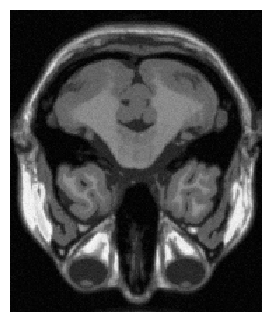

In [4]:
idx = 33
beta = 10
img = cv.imread('../image/t1/outImg'+str(idx)+'.bmp',0)
_,mask = cv.threshold(img,beta,255,0)
mask = binary_fill_holes(mask)
image = img*mask
image = crop_image(img)
plt.axis('off')
plt.imshow(image)

0.13227497835801197 0.08327321982310135


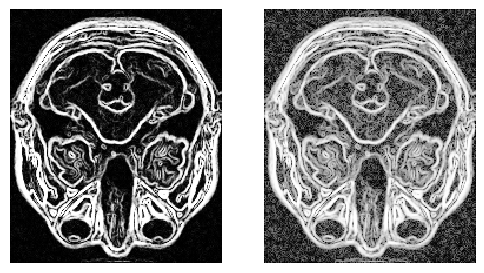

In [5]:
scharr = homogeneity.get_scharr_mhue(image)
scharr_n = (1 - np.exp(-((scharr/255)**2/(np.var(scharr)/scharr.size))))
scharr_n2 = homogeneity.rank_normalize_mhue(scharr)
print(np.var(scharr_n),np.var(scharr_n2))

plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(scharr_n)
plt.subplot(122)
plt.axis('off')
plt.imshow(scharr_n2)

In [6]:
import numba
from numba import jit,njit

In [7]:
t1 = np.min(image) + 2
t2 = np.max(image) - 2
bdts_o = []
bdts_b = []
for t in range(t1, t2):
    # object
    _, src = cv.threshold(image, t, 255, cv.THRESH_BINARY)
    bdt_o = distance_transform_cdt(src,return_distances=True)
    bdts_o.append(bdt_o)
    # background
    src = 255-src
    bdt_b = distance_transform_cdt(src,return_distances=True)
    bdts_b.append(bdt_b)

In [8]:
# stabs = load_pickle('../pickle/stab'+str(idx)+'.pkl')
stabs = stability.get_stability(image,bdts_o)

/home/yk/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'bdt' of function '__windowing'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../newutils/stability.py", line 33:
@jit(nopython=True)
def __windowing(image, bdt, t, width, r_max, neighbours_min, idx):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/yk/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'idx' of function '__windowing'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../newutils/stability.

../newutils/mhue.py:57: RuntimeWarning: divide by zero encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newutils/mhue.py:57: RuntimeWarning: invalid value encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newutils/mhue.py:71: RuntimeWarning: divide by zero encountered in log
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../newutils/mhue.py:71: RuntimeWarning: invalid value encountered in multiply
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../newutils/mhue.py:56: RuntimeWarning: divide by zero encountered in true_divide
  p_o = np.exp(-np.power(img - mean_o, 2) / (2 * var_o)) / (math.sqrt(2 * math.pi * var_o))
../newutils/mhue.py:56: RuntimeWarning: invalid value encountered in true_divide
  p_o = np.exp(-np.power(img - mean_o, 2) / (2 * var_o)) / (math.sqrt(2 * math.pi * var_o))
../newutils/mhue.py:68: 

(array([ 27,  69, 143]),)


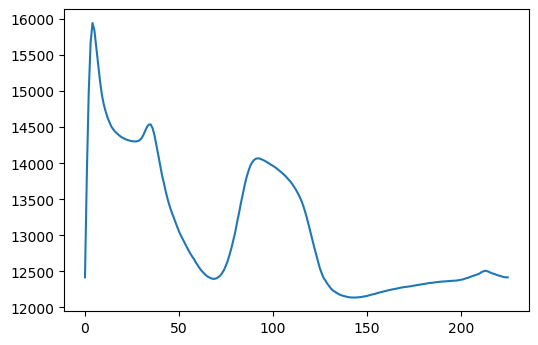

In [9]:
uncertainty = mhue.get_uncertainty(image)
mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr_n)
uncertaintyw = mhue.get_uncertainty(image, off_center=True, info_w=True, stabs=stabs, 
                                    bdts_o=bdts_o, bdts_b=bdts_b, kernel_size=15,sigma=1)
mhuew_img = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr_n)

mhue_cum = list(map(lambda x:np.sum(x),mhue_img))
plt.plot(mhue_cum)
print(argrelmin(np.array(mhue_cum)))

In [32]:
score = get_score(image,uncertaintyw,scharr_n,3)

In [33]:
scharr_nb, delta = bound.get_scharr_bounding(image, scharr_n, bdts_o, bdts_b, 60)
scoreb = get_score(image,uncertaintyw,scharr_nb,3,bounding=True)

0.08584761994379013


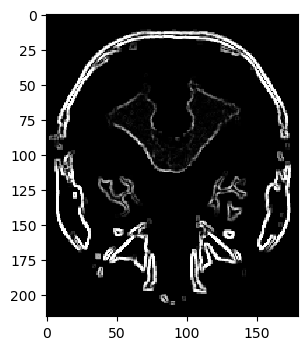

In [34]:
plt.imshow(scharr_nb[100])
print(np.mean(scharr_nb[100]))

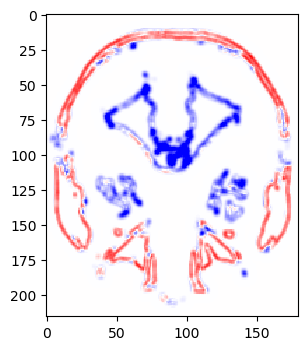

In [35]:
plt.imshow(scoreb[100],cmap='bwr',norm=norm)

(array([ 18,  51,  65, 100, 131]),)

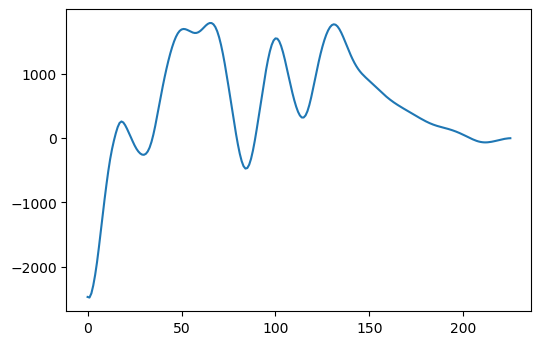

In [54]:
_r = list(map(lambda x:np.sum(x),score))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.1:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon, order=10)

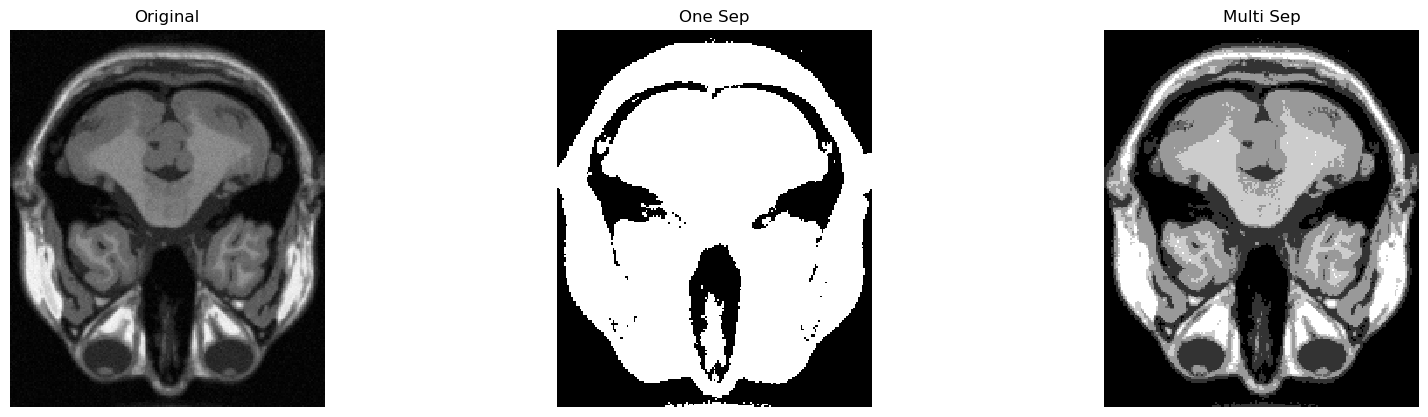

In [55]:
region_maxt = argrelmax(_r_recon, order=5)[0]
# region_maxt = np.array([60,100,170])
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.axis('off')
plt.title('Original')
plt.imshow(image,cmap='gray')

n_sep = region_maxt.size
sep = np.zeros(shape=img.shape) * 255
for n in range(n_sep):
    _,tmp = cv.threshold(img,region_maxt[n],255,0)
    if n==0:
        plt.subplot(132)
        plt.axis('off')
        plt.title('One Sep')
        plt.imshow(tmp,cmap='gray')
    sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
plt.subplot(133)
plt.axis('off')
plt.title('Multi Sep')
plt.imshow(sep,cmap='gray')

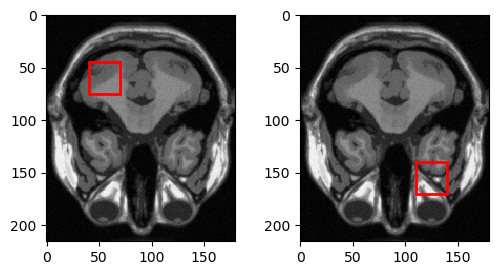

In [39]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(image)
# (min_row, min_col, max_row, max_col)
bbox = [45, 40, 75, 70]
bbox2 = [140, 110, 170, 140]
plt.gca().add_patch(plt.Rectangle(xy=(bbox[1], bbox[0]),width=bbox[3] - bbox[1], 
                                  height=bbox[2] - bbox[0], edgecolor='r', fill=False, linewidth=2))

plt.subplot(122)
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle(xy=(bbox2[1], bbox2[0]),width=bbox2[3] - bbox2[1], 
                                  height=bbox2[2] - bbox2[0], edgecolor='r', fill=False, linewidth=2))

In [95]:
def __partialplot(image, scharr, uncertaintyw, score, stabs, bbox, t, bounding=False):
    import matplotlib
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    
    if bounding:
        scharr_n = scharr[t]
    else:
        scharr_n = scharr.copy()
    
    plt.figure(figsize=(35,5))
    plt.subplot(161)
    plt.imshow(image[bbox[0]:bbox[2],bbox[1]:bbox[3]])
    plt.subplot(162)
    plt.imshow(uncertaintyw[t].reshape(image.shape)[bbox[0]:bbox[2],bbox[1]:bbox[3]])
    plt.subplot(163)
    plt.imshow(scharr_n[bbox[0]:bbox[2],bbox[1]:bbox[3]])
    plt.subplot(164)
    plt.imshow(stabs[t][bbox[0]:bbox[2],bbox[1]:bbox[3]],cmap='GnBu')
    plt.colorbar()
    plt.subplot(165)
    _,tmp = cv.threshold(image,t+2,255,0)
    plt.imshow(tmp[bbox[0]:bbox[2],bbox[1]:bbox[3]])
    plt.subplot(166)
    mask = np.where(stabs[t][bbox[0]:bbox[2],bbox[1]:bbox[3]]==0)
    score_loc = score[t][bbox[0]:bbox[2],bbox[1]:bbox[3]].copy()
    # score_loc[mask] = 0
    
    print('mean: {:.6f}, sum: {:.6f}'.format(np.sum(score_loc)/np.sum(np.where(score_loc!=0)),np.sum(score_loc)))
    plt.imshow(image[bbox[0]:bbox[2],bbox[1]:bbox[3]], alpha=0.7)
    plt.imshow(score_loc, cmap='bwr', norm=norm, alpha=0.5)
    # plt.imshow(score_loc)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    plt.close()

0.00046031109002823956


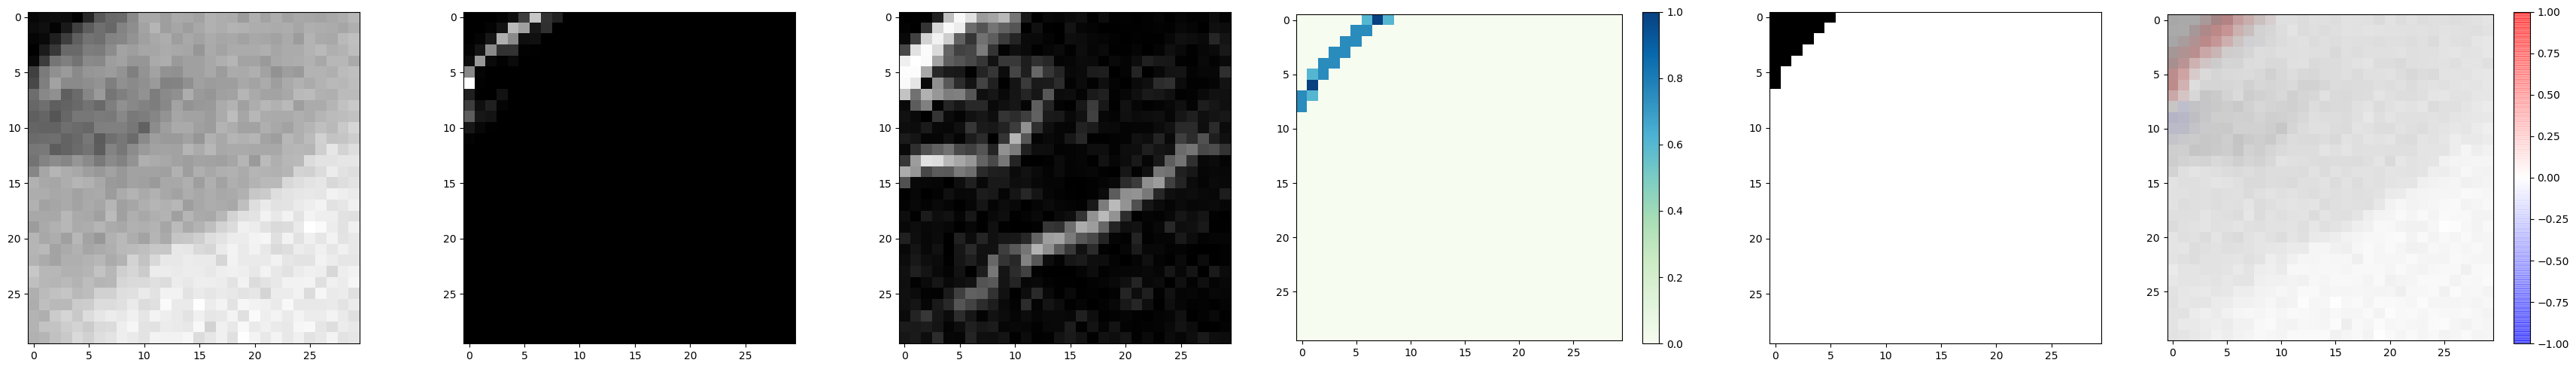

In [41]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox, 40)

-0.0013543794954765538


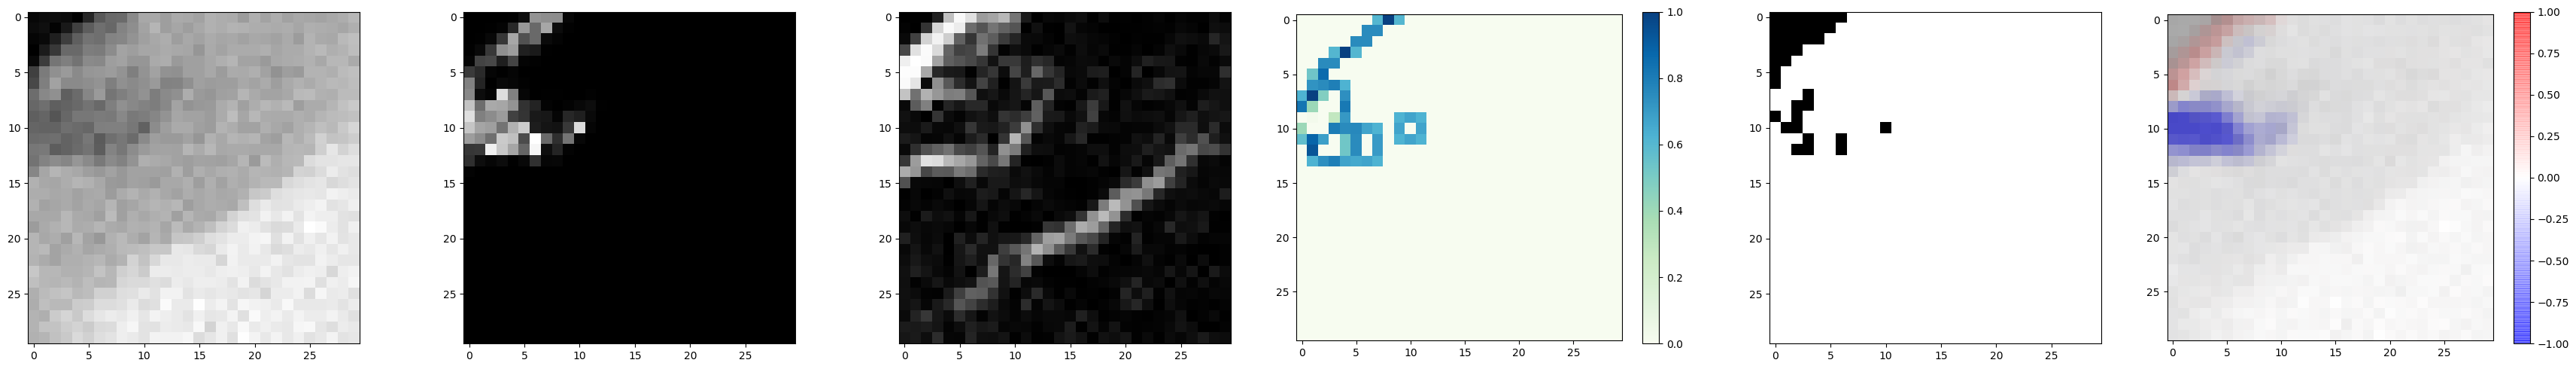

In [42]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox, 50)

-0.006496554793862392


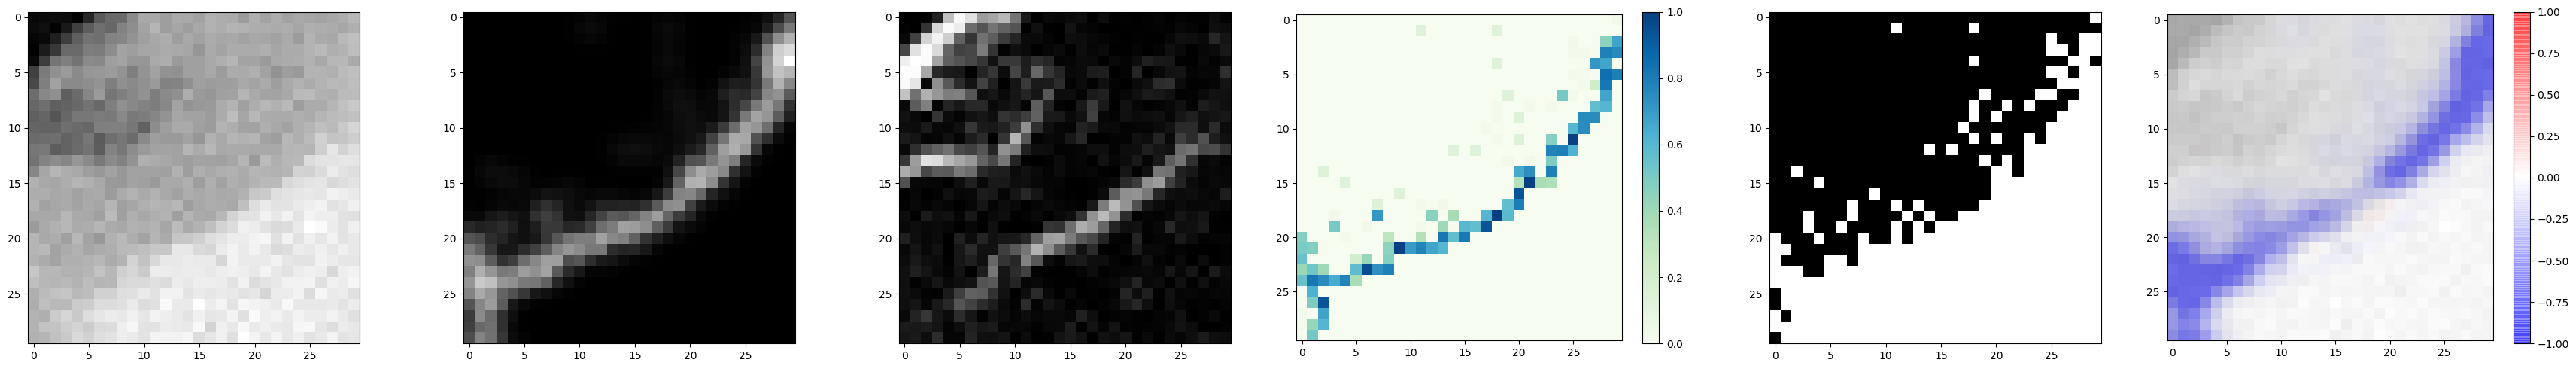

In [43]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox, 90)

-0.003334284463885914


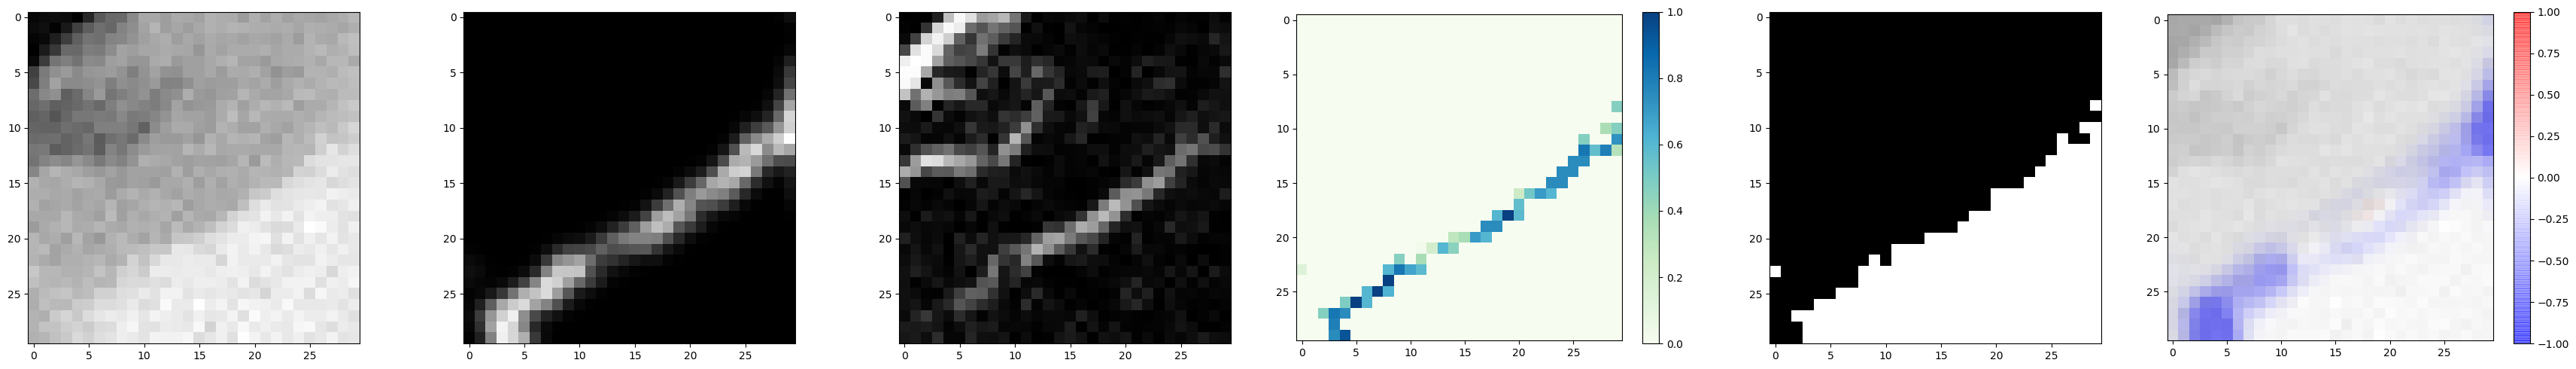

In [44]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox, 100)

-0.00144833731402774


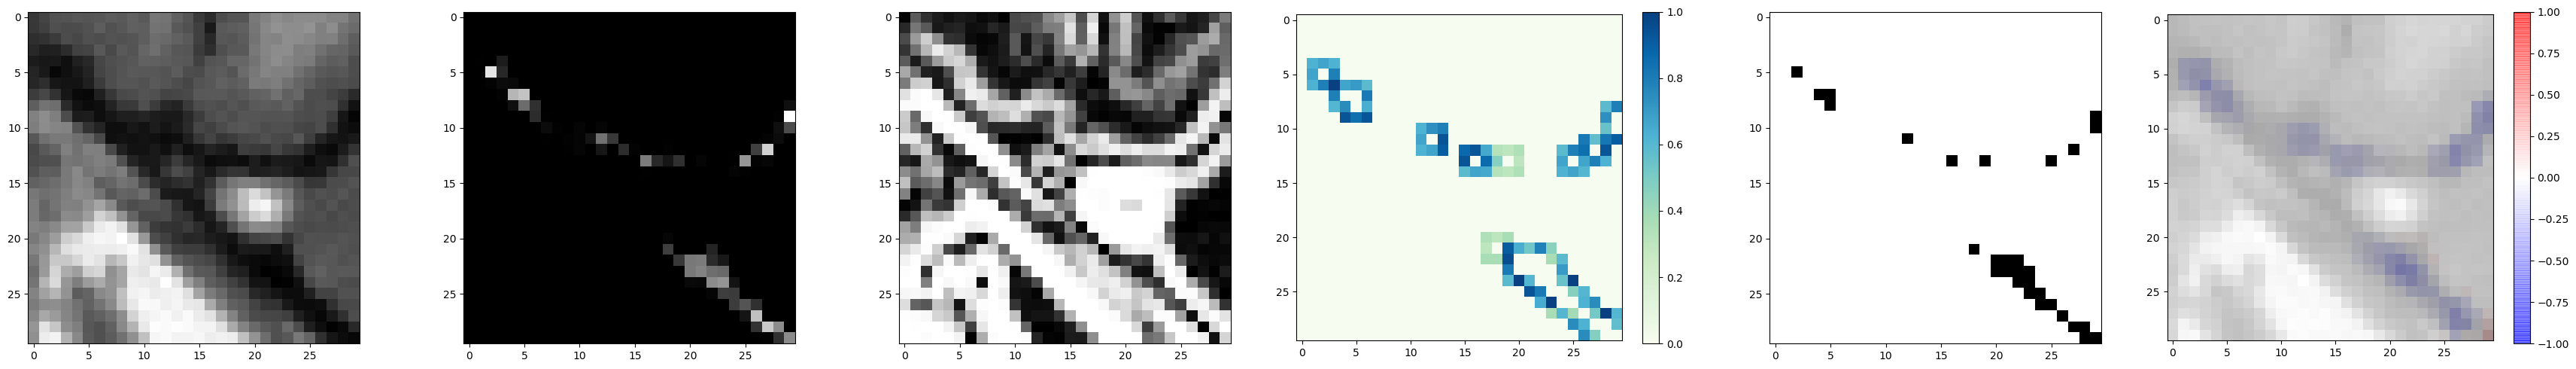

In [45]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox2, 30)

0.0012054645940994871


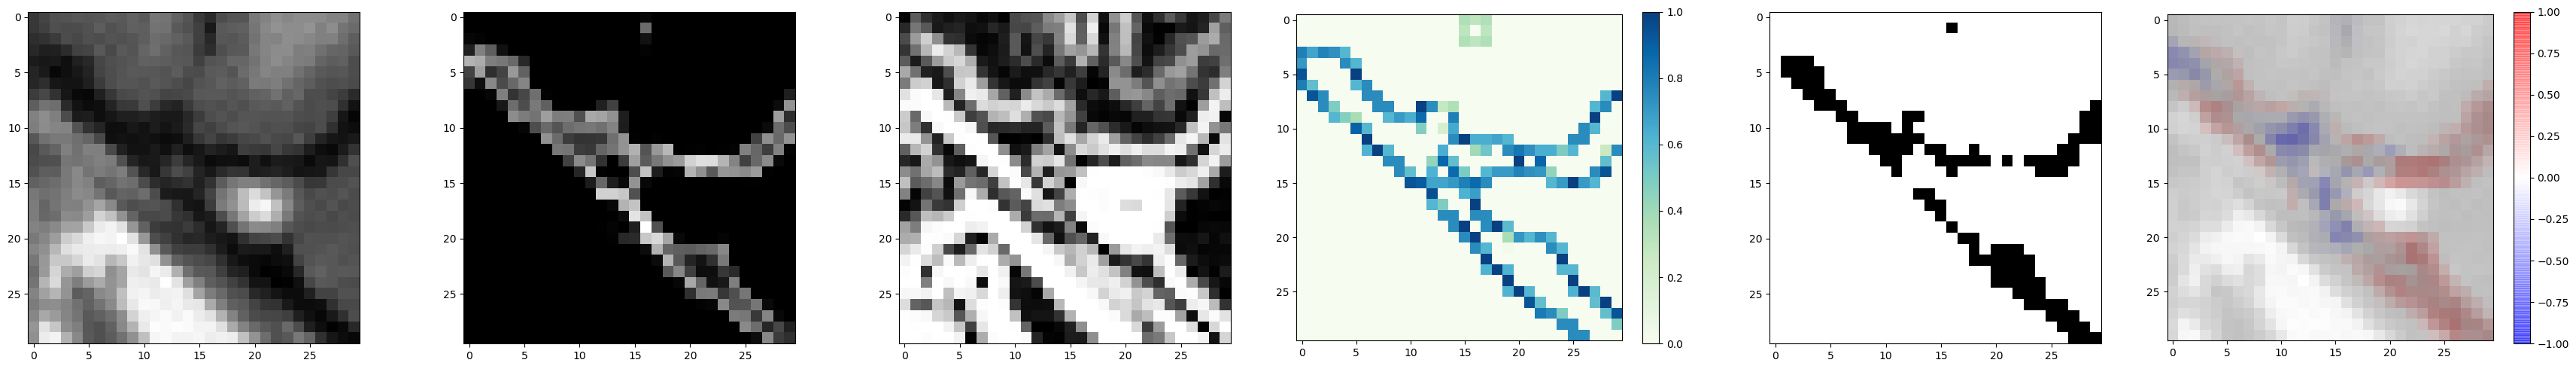

In [46]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox2, 40)

0.0026568190503124456


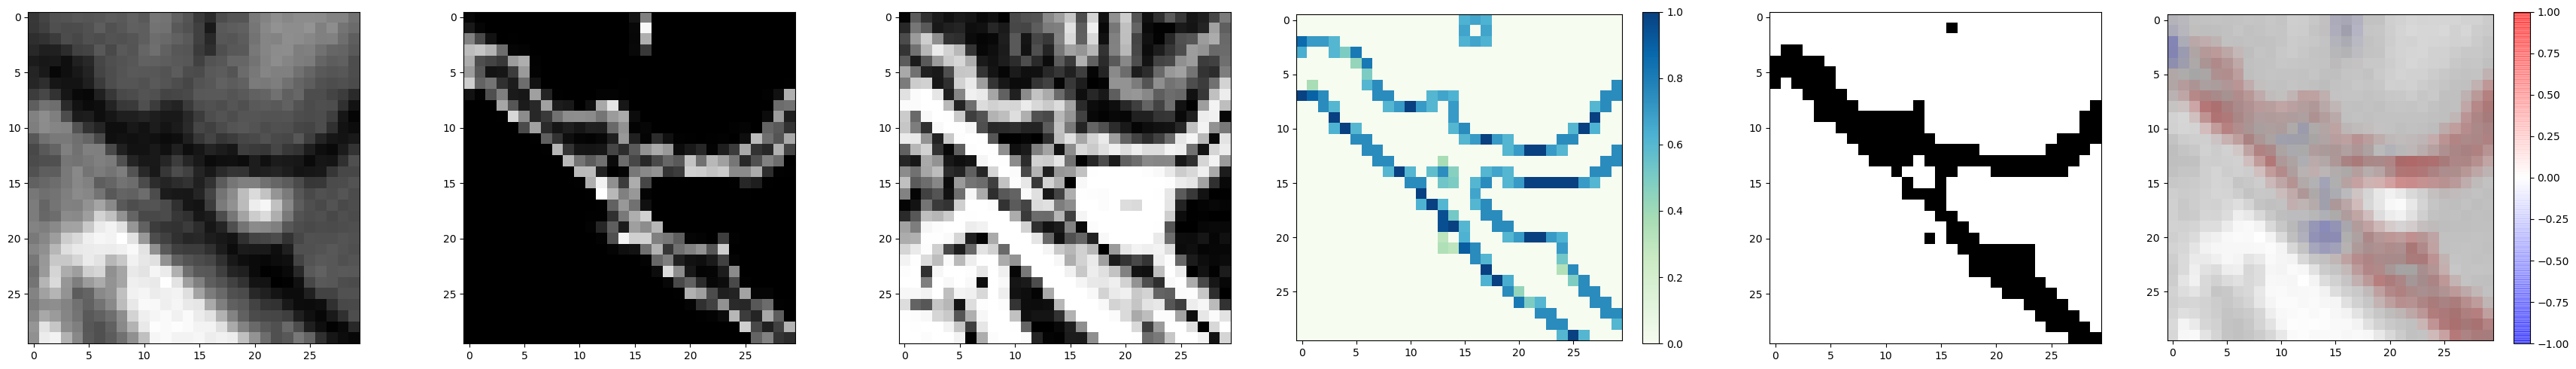

In [47]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox2, 50)

0.00183151467098445


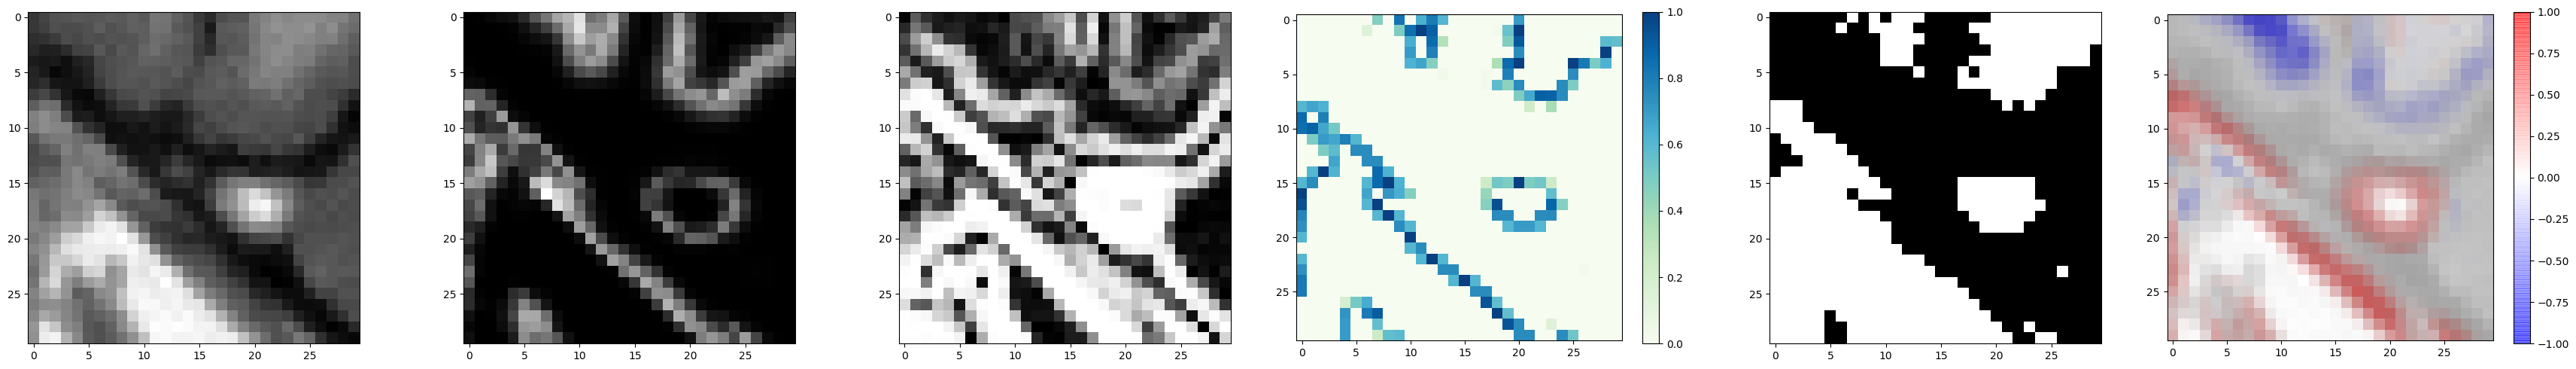

In [48]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox2, 90)

0.0034257859029949364


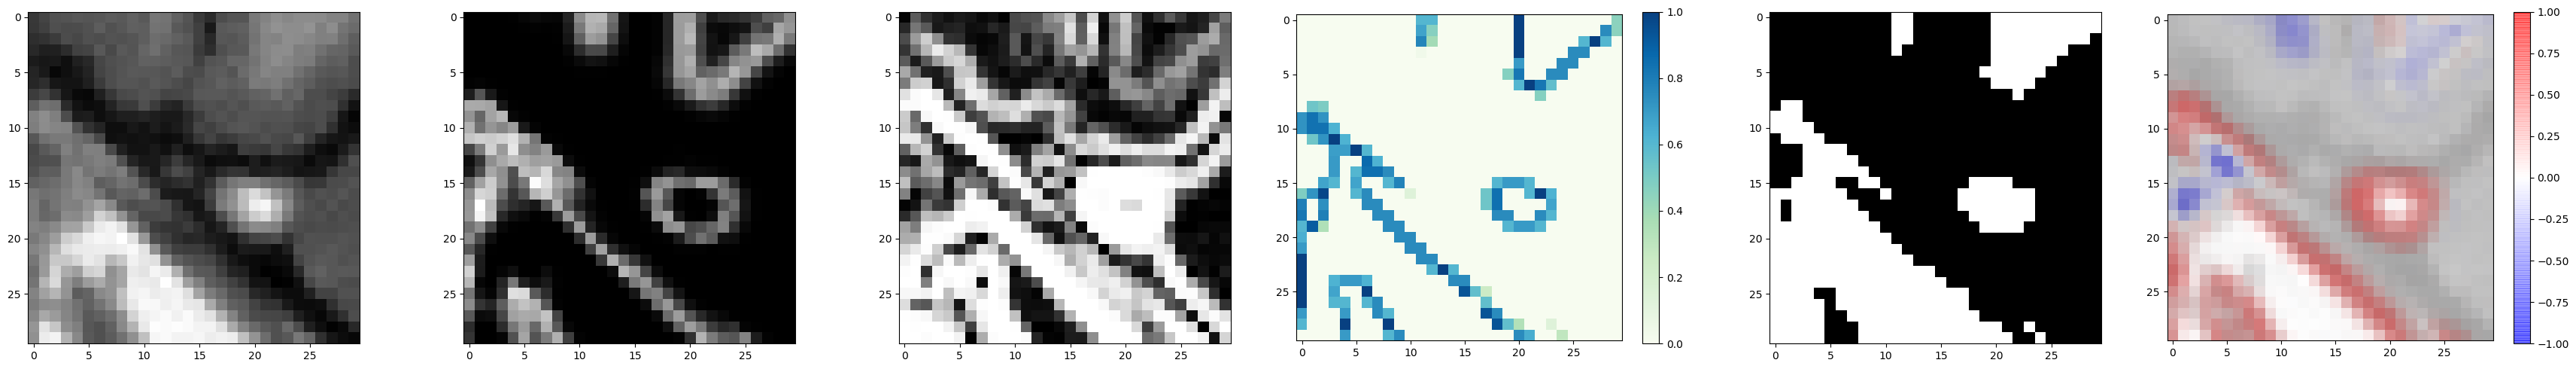

In [49]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox2, 100)

0.003395537867297893


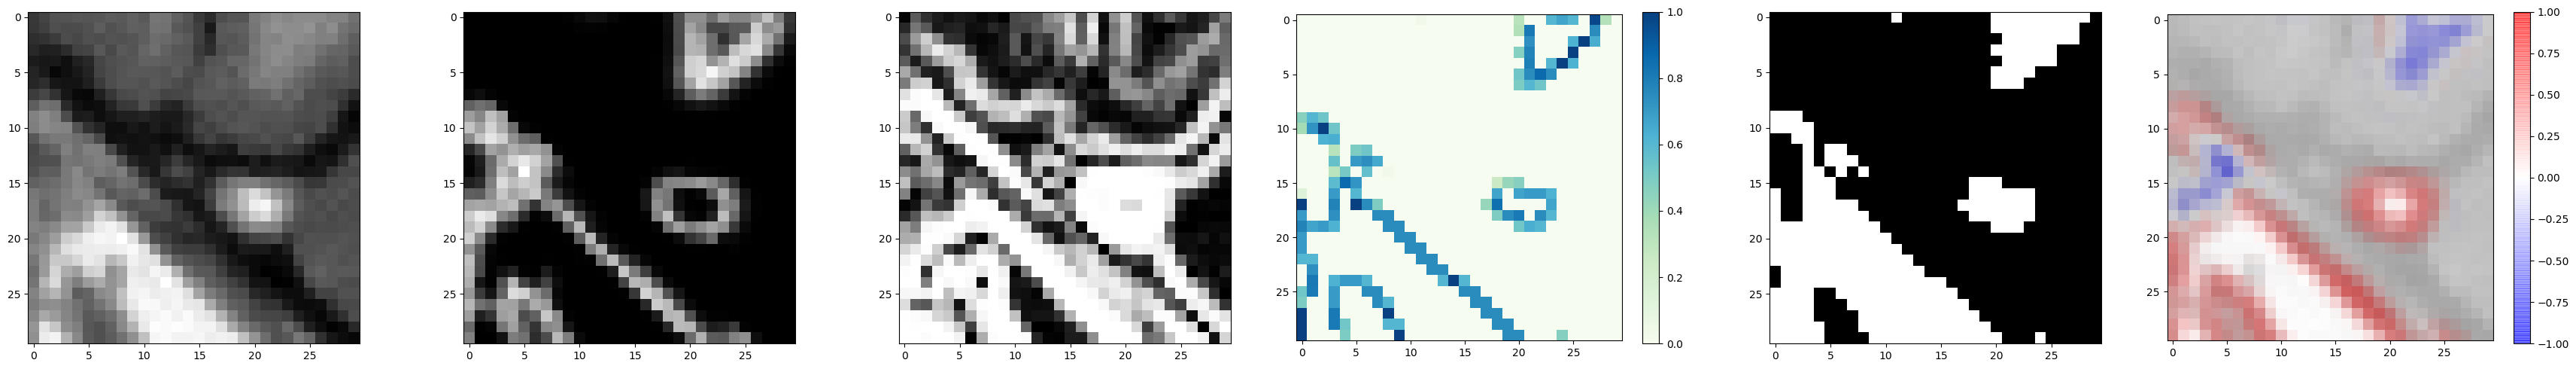

In [50]:
__partialplot(image, scharr_n, uncertaintyw, score, stabs, bbox2, 110)

(array([ 17,  49,  99, 132]),)

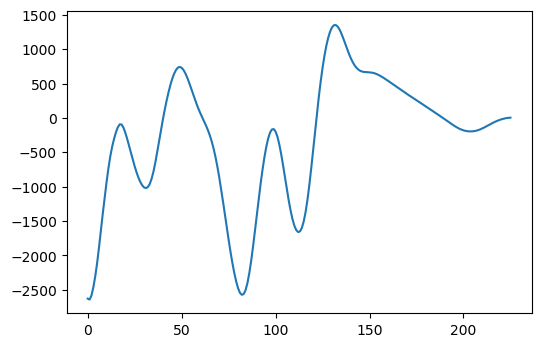

In [52]:
_r = list(map(lambda x:np.sum(x),scoreb))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.1:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon, order=10)

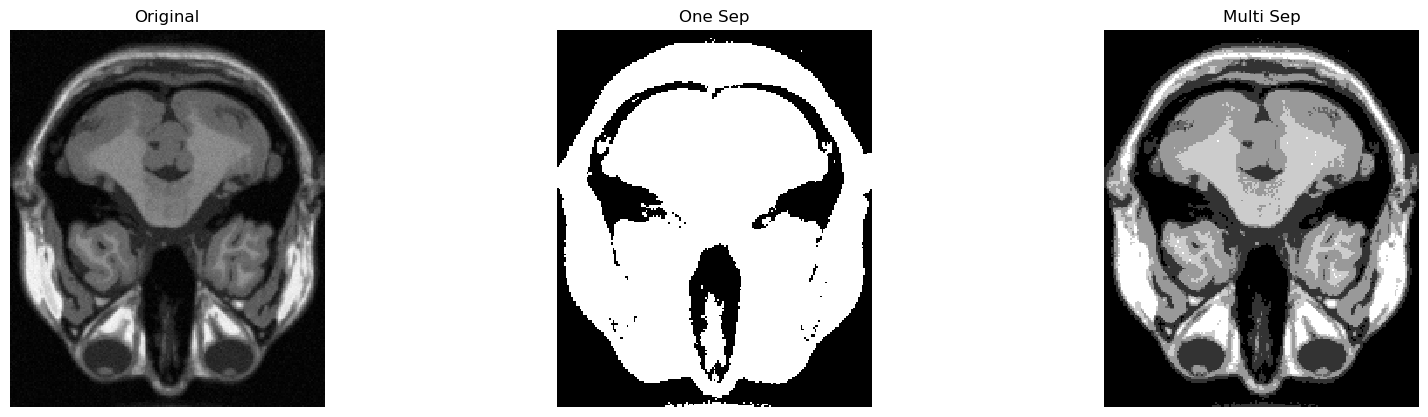

In [56]:
region_maxt = argrelmax(_r_recon, order=5)[0]
region_maxt = region_maxt[np.where(region_maxt>10)]
# region_maxt = np.array([60,100,170])
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.axis('off')
plt.title('Original')
plt.imshow(image,cmap='gray')

n_sep = region_maxt.size
sep = np.zeros(shape=img.shape) * 255
for n in range(n_sep):
    _,tmp = cv.threshold(img,region_maxt[n],255,0)
    if n==0:
        plt.subplot(132)
        plt.axis('off')
        plt.title('One Sep')
        plt.imshow(tmp,cmap='gray')
    sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
plt.subplot(133)
plt.axis('off')
plt.title('Multi Sep')
plt.imshow(sep,cmap='gray')

8.830034976921957e-05


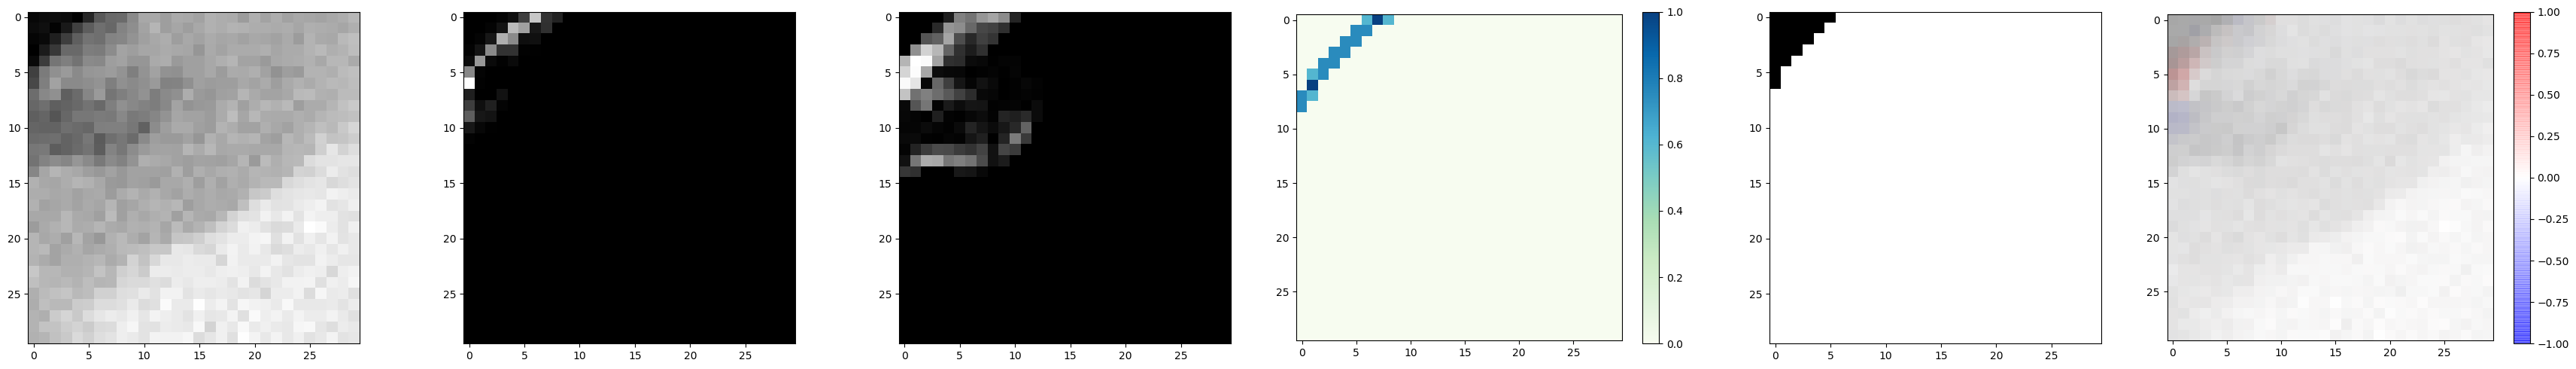

In [57]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox, 40, bounding=True)

-0.00230222381482377


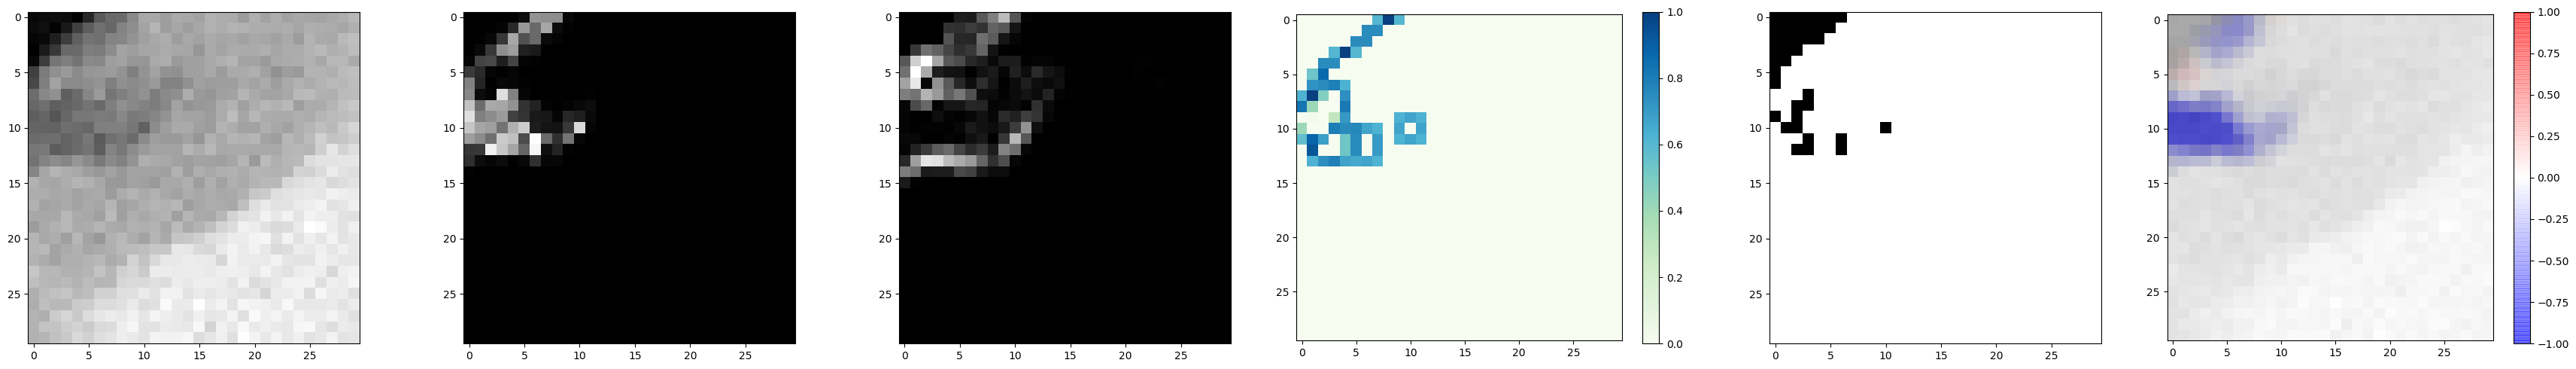

In [58]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox, 50, bounding=True)

-0.007443185213073282


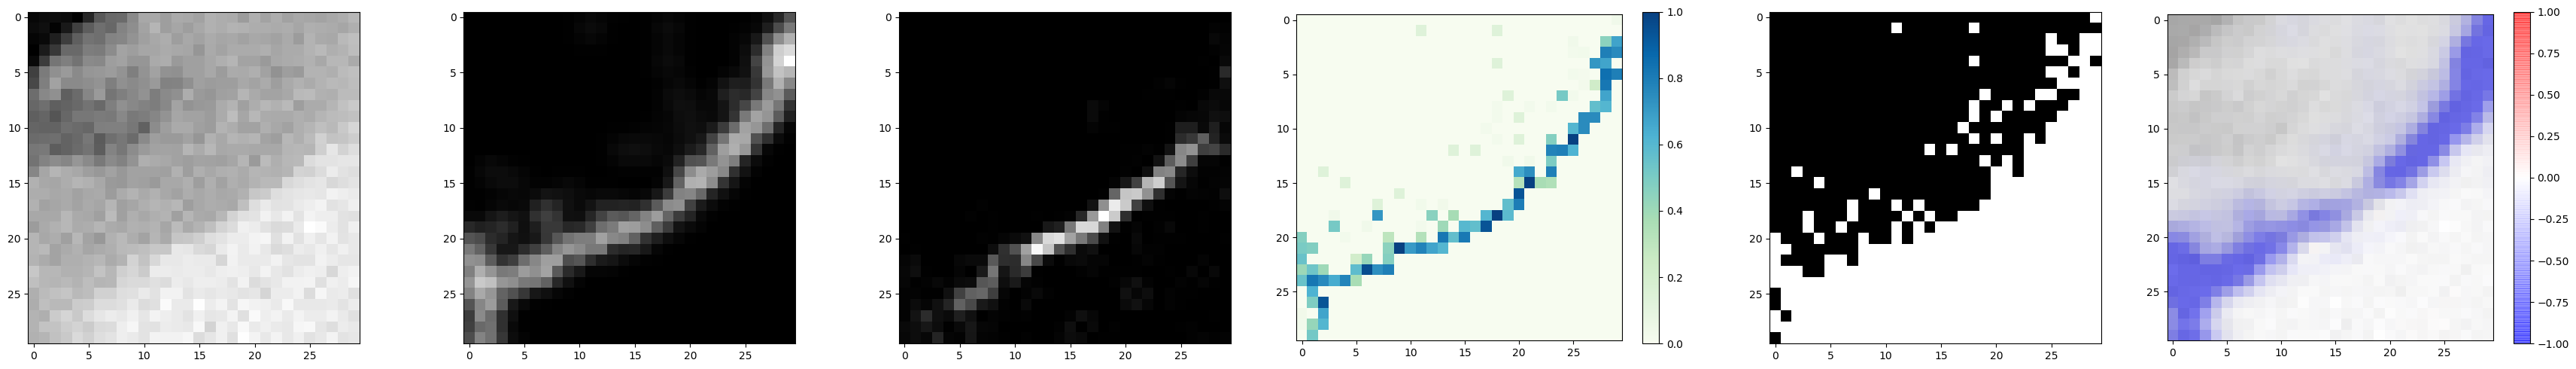

In [59]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox, 90, bounding=True)

-0.004780754823508734


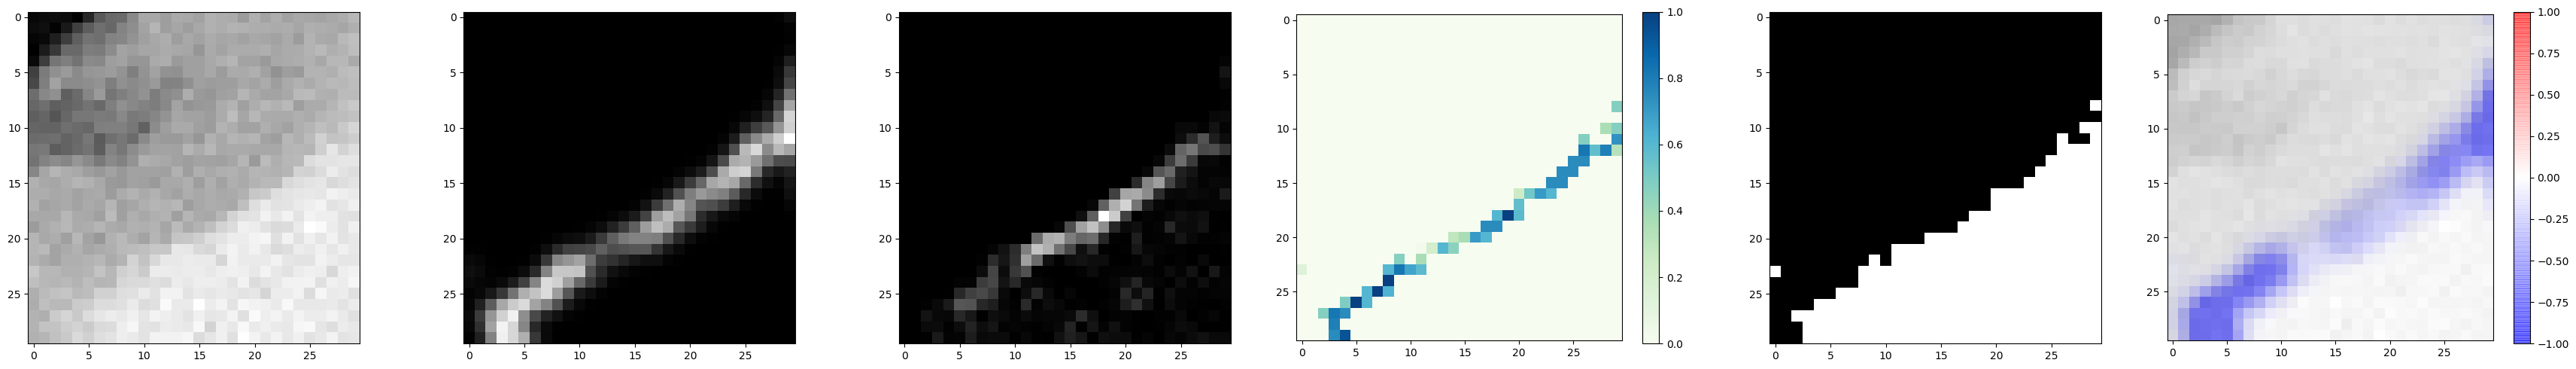

In [60]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox, 100, bounding=True)

-0.008754134544125167


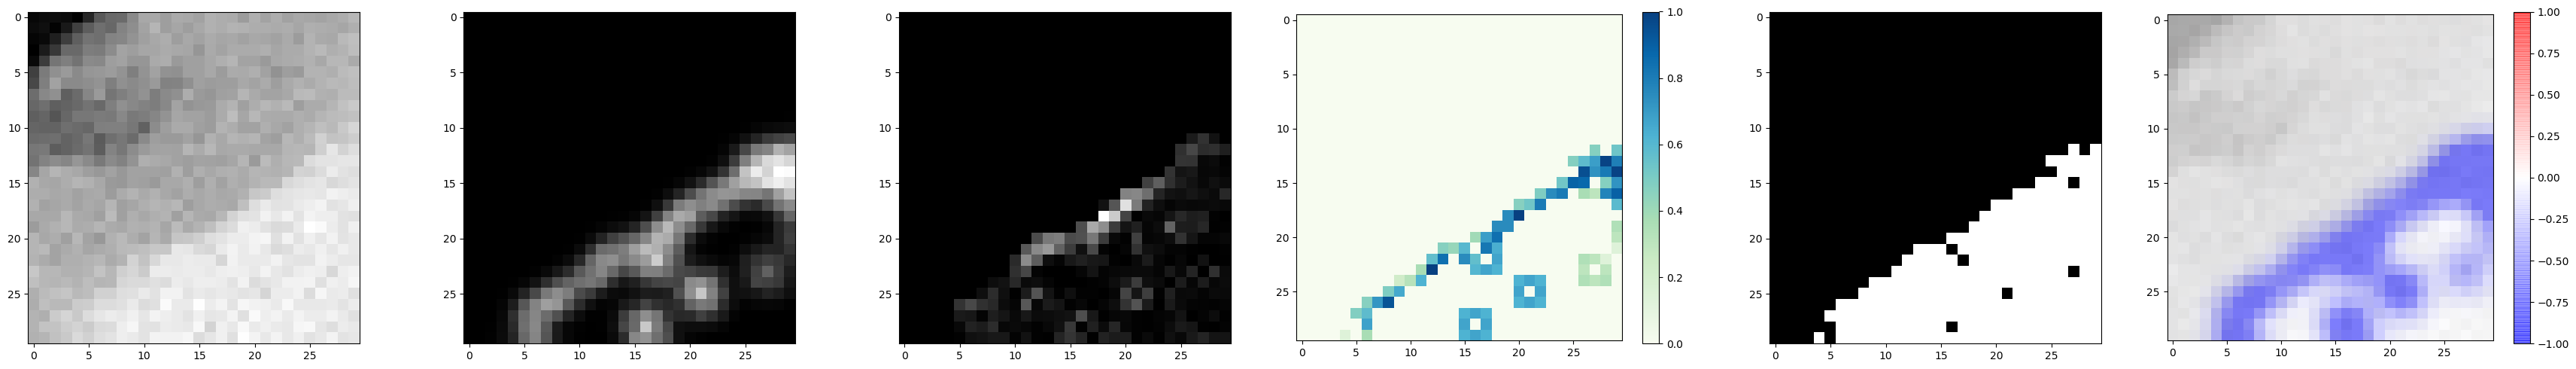

In [61]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox, 110, bounding=True)

-0.001618307950477212


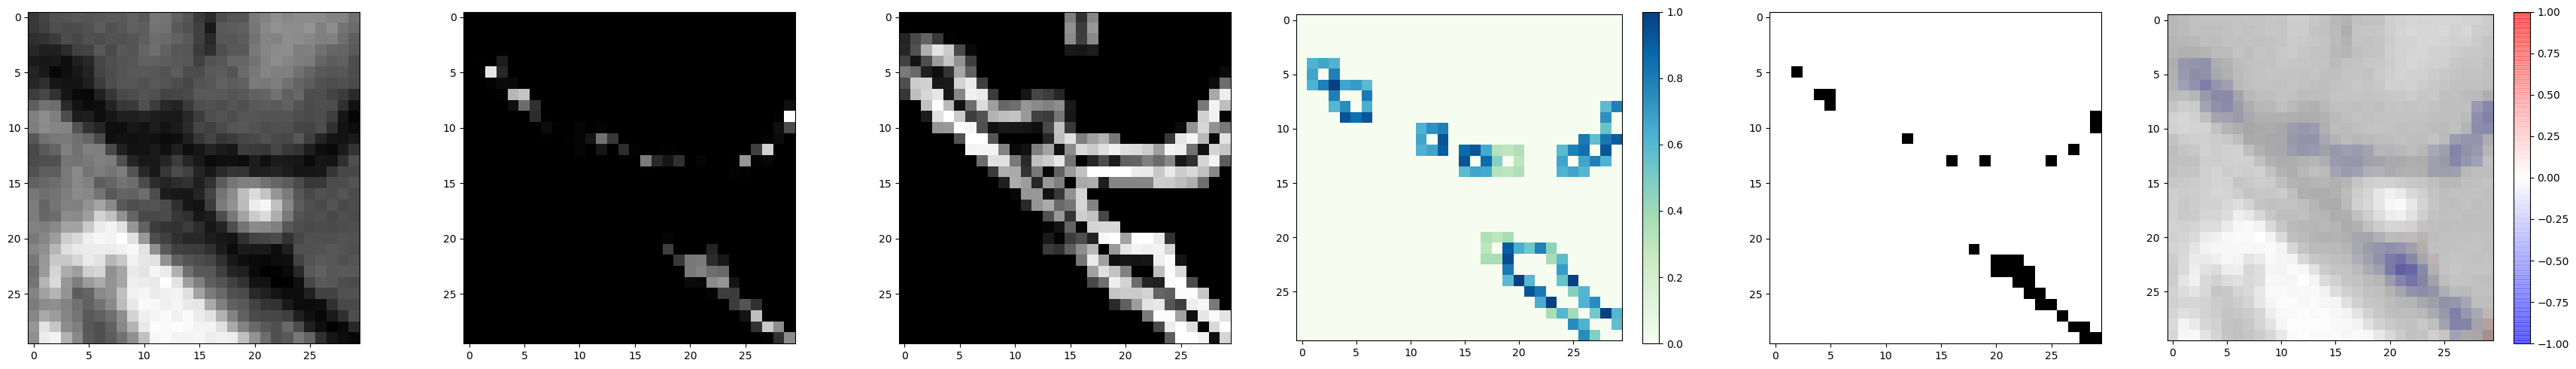

In [62]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox2, 30, bounding=True)

0.0007294340448435384


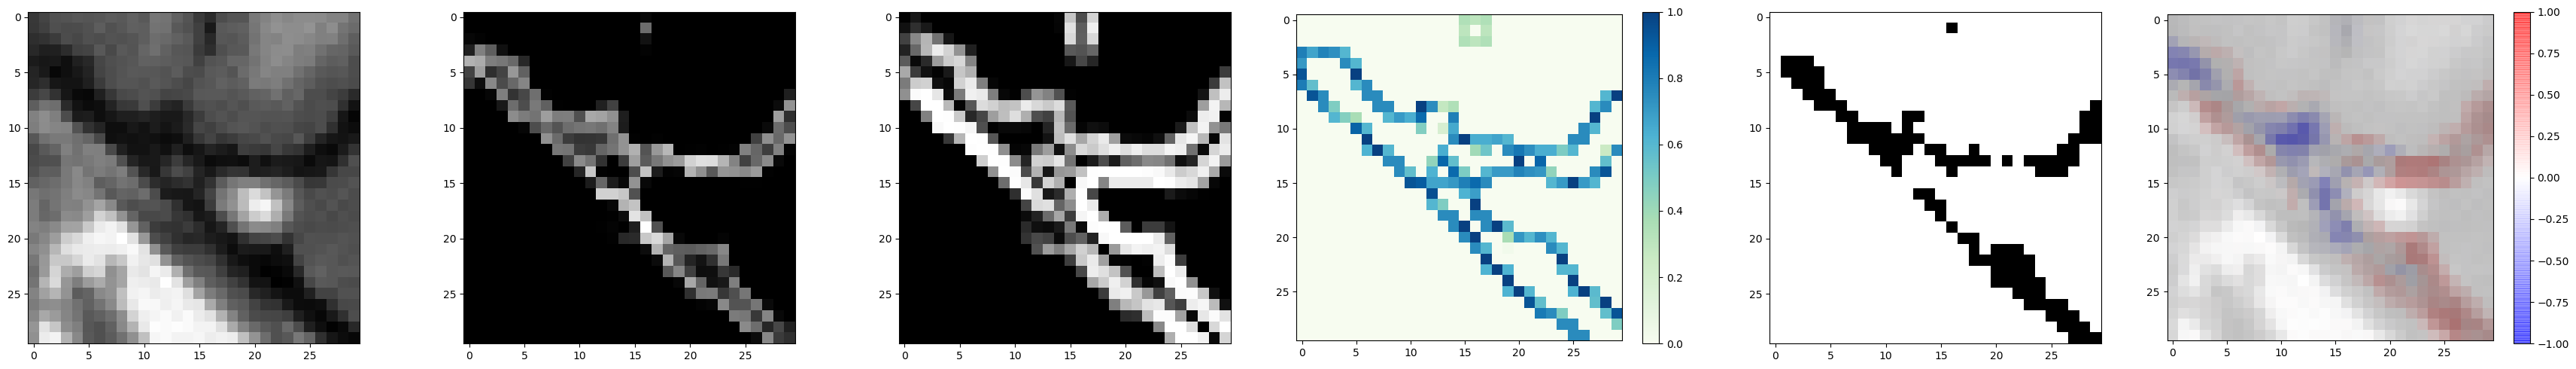

In [63]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox2, 40, bounding=True)

0.0017093224865227916


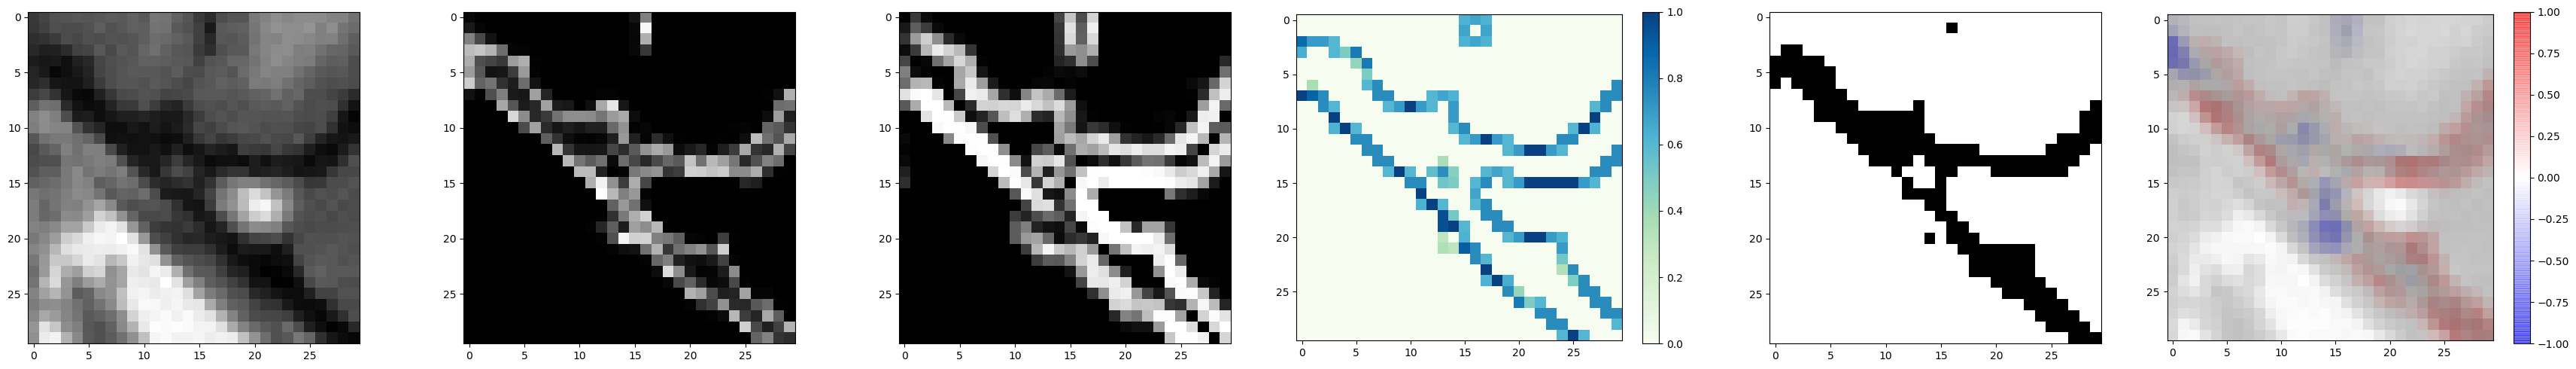

In [64]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox2, 50, bounding=True)

-0.00016639364156599218


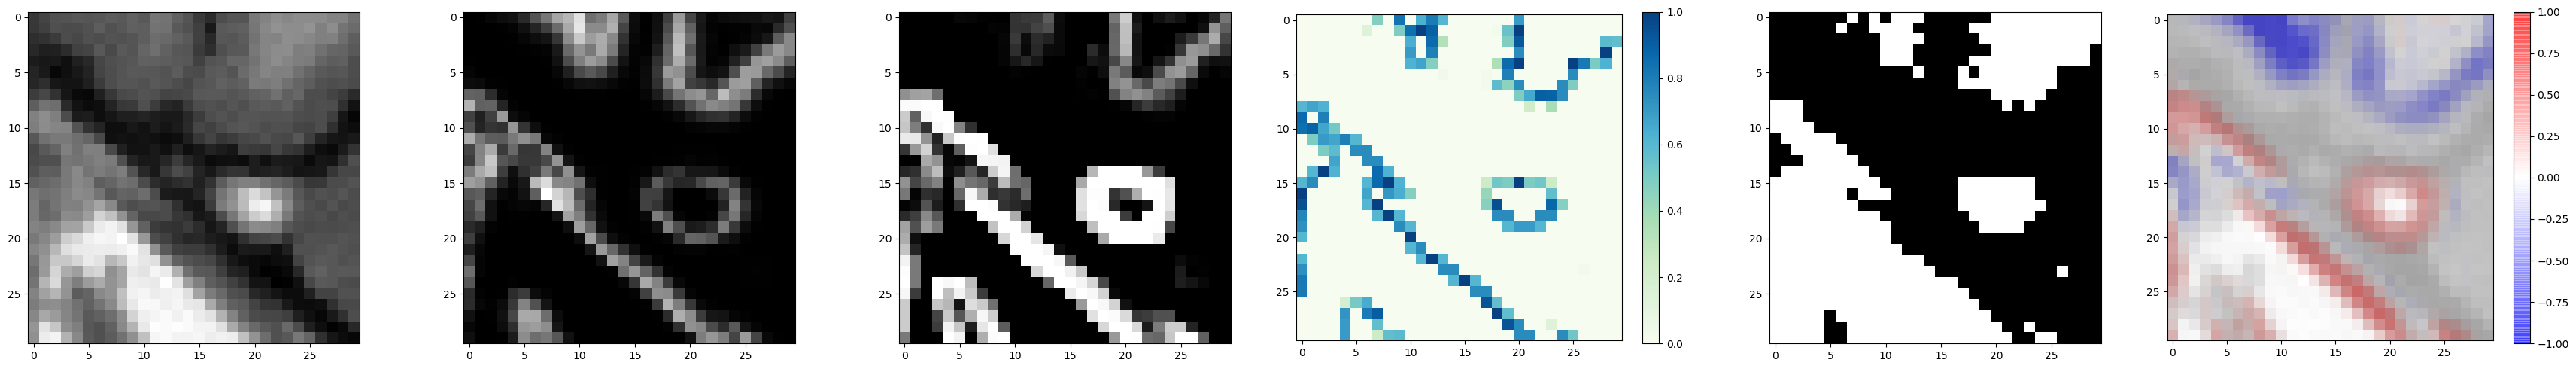

In [65]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox2, 90, bounding=True)

0.00048563388541735344


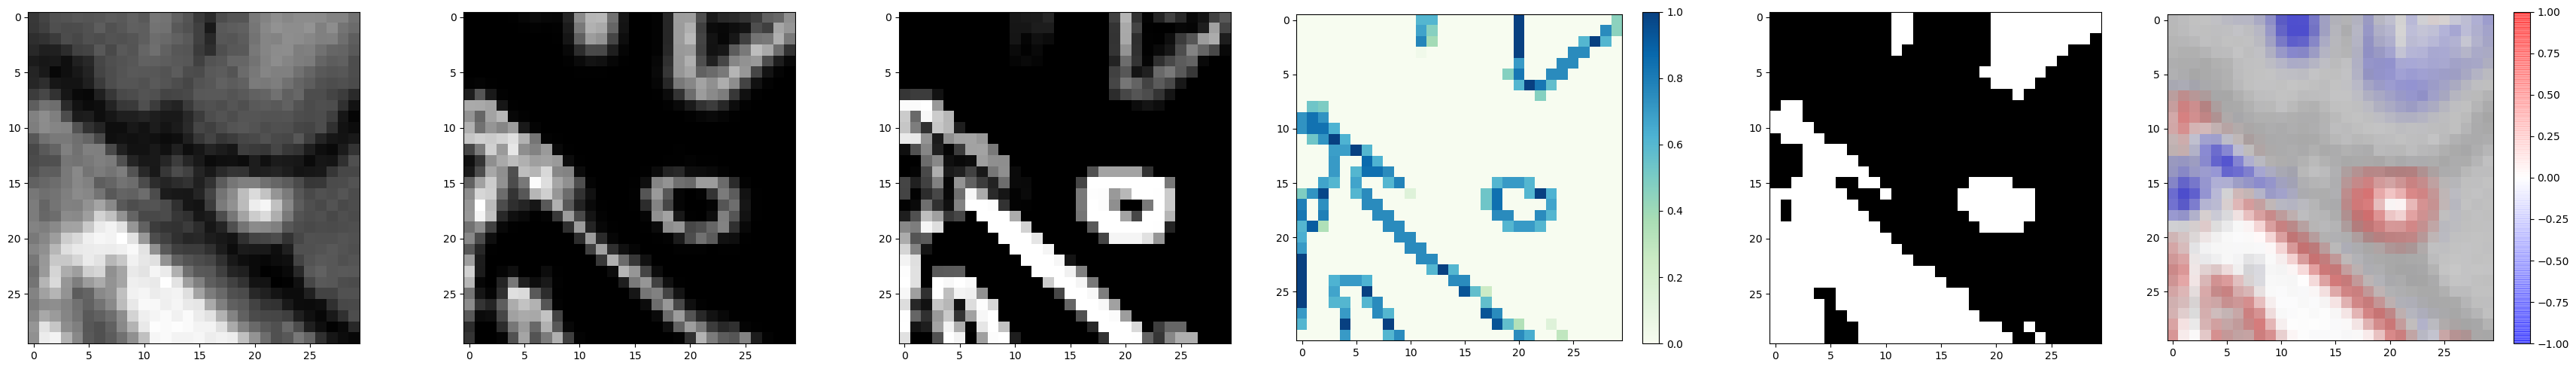

In [66]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox2, 100, bounding=True)

-0.0005683480028653854


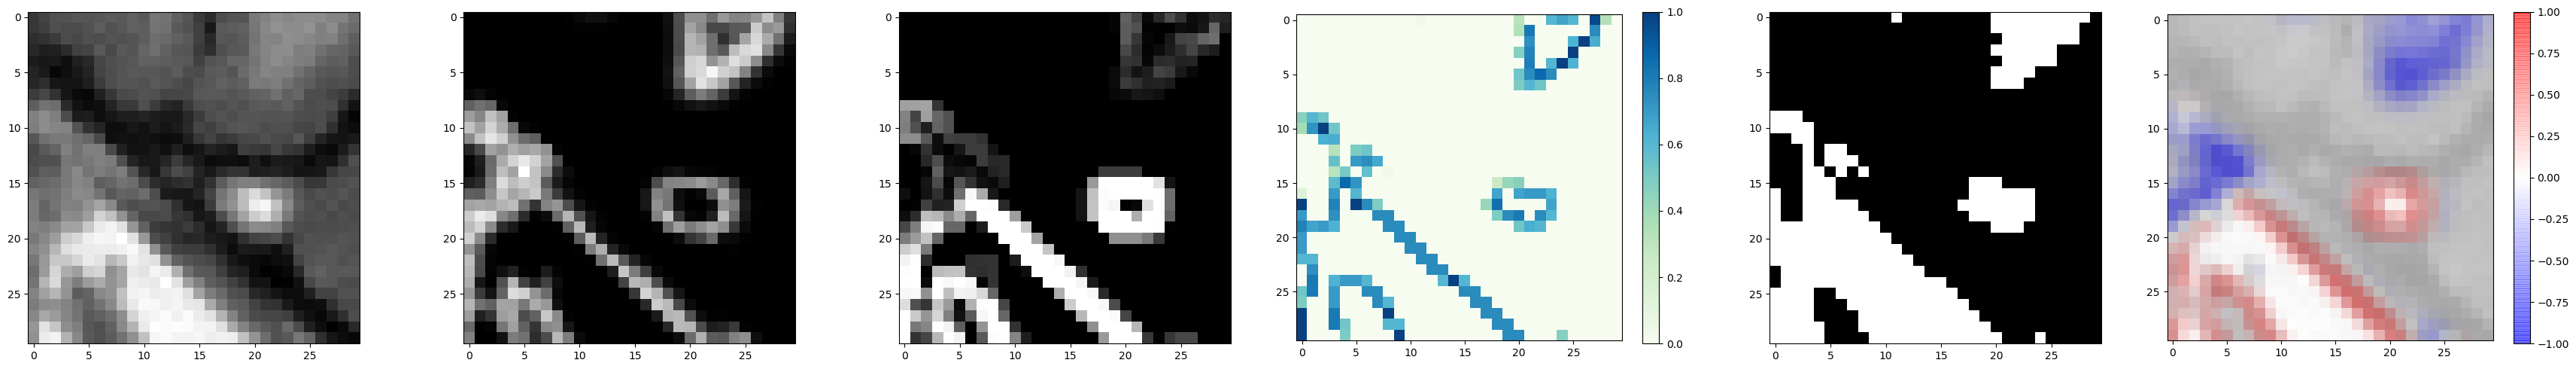

In [67]:
__partialplot(image, scharr_nb, uncertaintyw, scoreb, stabs, bbox2, 110, bounding=True)

In [30]:
def get_bound(image, bdts_o):
    edgeness = []
    for t in range(len(bdts_o)):
        fil = mhue.gauss_kernel(kernel_size=3, sigma=1)
        bdt = bdts_o[t]
        edge = np.zeros(shape=bdt.shape)
        edge[np.where(bdt==1)] = 1
        edge = cv.filter2D(edge,-1,fil)
        edge[np.where(edge<0.1)] = 0
        edge[np.where(edge>=0.1)] = 1
        edgeness.append(edge.flatten())
    
    # edgeness: (t, flatten_image_pixel)
    edgeness = np.array(edgeness)
    lower, upper = [0] * edgeness.shape[1], [0] * edgeness.shape[1]
    for i in range(edgeness.shape[1]):
        p = edgeness[:,i]
        if np.sum(p) == 0:
            continue
        lower[i] = np.min(np.where(p == 1))
        upper[i] = np.max(np.where(p == 1))
    lower, upper = np.array(lower), np.array(upper)
    return lower, upper

In [31]:
lower, upper = get_bound(image, bdts_o)

In [36]:
np.percentile(upper-lower,30)

11.0

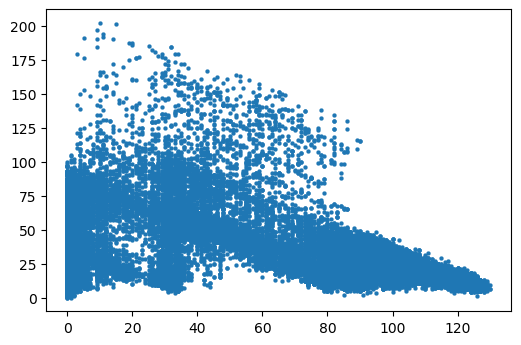

In [79]:
plt.scatter(x=lower,y=upper-lower,marker='.',linewidths=0.1)

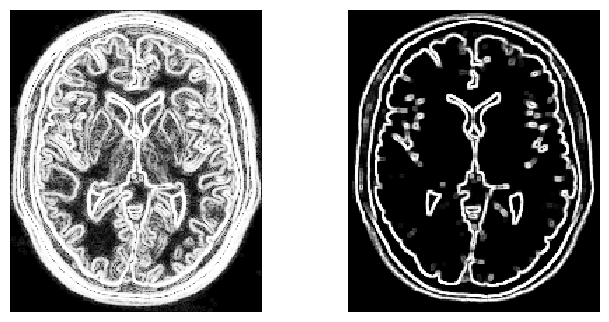

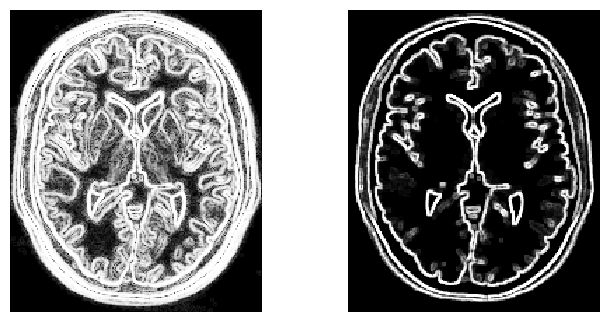

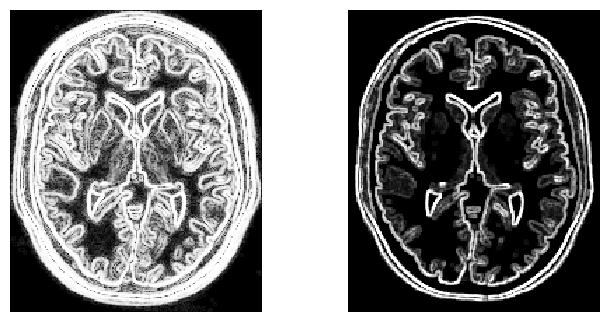

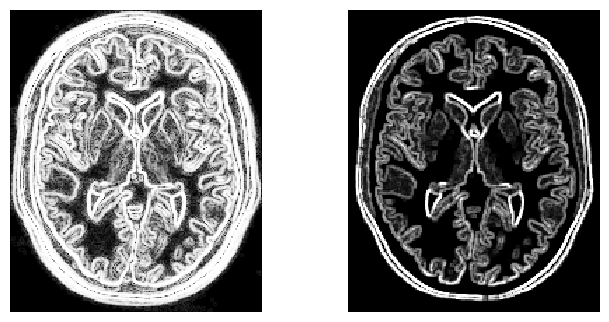

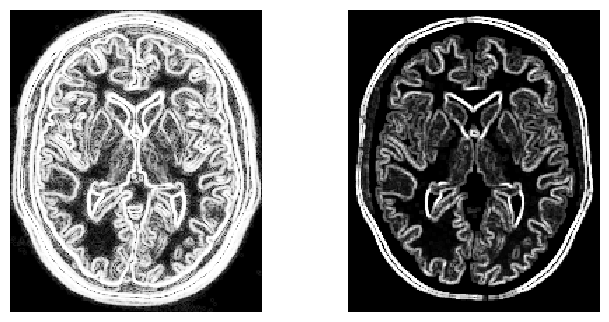

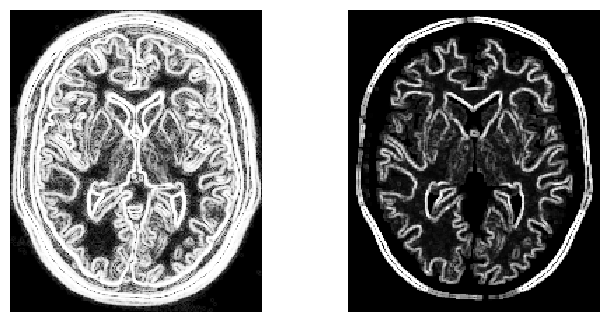

In [161]:
ts = [40, 50, 60, 70, 80, 90]
for t in ts:
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(scharr_n)
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(testsch[t])

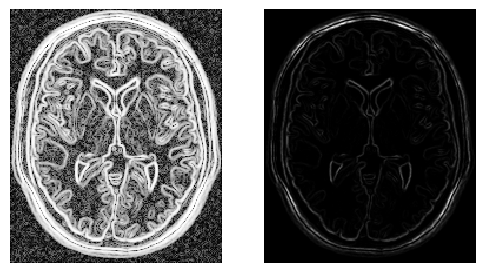

In [179]:
scharr = homogeneity.get_scharr_mhue(image)
scharr_n = homogeneity.rank_normalize_mhue(scharr)

scharr_n2 = (1 - np.exp(-((scharr/255)**2/(2*np.var(scharr)))))
scharr_n2 /= np.max(scharr_n2)

plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(scharr_n)
plt.subplot(122)
plt.axis('off')
plt.imshow(scharr_n2)

## IXI

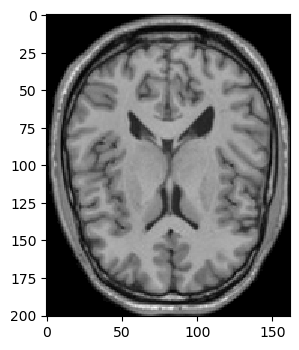

In [119]:
ixipath = '../image/ixi-N4corrected/'
ixiname = os.listdir(ixipath)
ixiimage = cv.imread(ixipath+ixiname[4],0)
ixiimage = preprocess.mask_image(ixiimage)
plt.imshow(ixiimage)

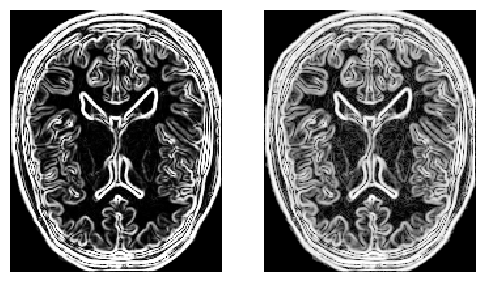

In [120]:
ixischarr = homogeneity.get_scharr_mhue(ixiimage)
# ixischarr_n = homogeneity.rank_normalize_mhue(ixischarr)
ixischarr_n = (1 - np.exp(-((ixischarr/255)**2/(np.var(ixischarr)/ixischarr.size))))
# ixischarr_n = homogeneity.rank_normalize_mhue(ixischarr)
ixischarr_n2 = homogeneity.rank_normalize_mhue(ixischarr)

plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(ixischarr_n)
plt.subplot(122)
plt.axis('off')
plt.imshow(ixischarr_n2)

In [121]:
t1 = np.min(ixiimage) + 2
t2 = np.max(ixiimage) - 2
ixibdts_o = []
ixibdts_b = []
for t in range(t1, t2):
    # object
    _, src = cv.threshold(ixiimage, t, 255, cv.THRESH_BINARY)
    ixibdt_o = distance_transform_cdt(src,return_distances=True)
    ixibdts_o.append(ixibdt_o)
    # background
    src = 255-src
    ixibdt_b = distance_transform_cdt(src,return_distances=True)
    ixibdts_b.append(ixibdt_b)

In [122]:
ixistabs = stability.get_stability(ixiimage,ixibdts_b)

../newutils/mhue.py:57: RuntimeWarning: divide by zero encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newutils/mhue.py:57: RuntimeWarning: invalid value encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../newutils/mhue.py:71: RuntimeWarning: divide by zero encountered in log
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../newutils/mhue.py:71: RuntimeWarning: invalid value encountered in multiply
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)


(array([  2,   6,  77, 196]),)


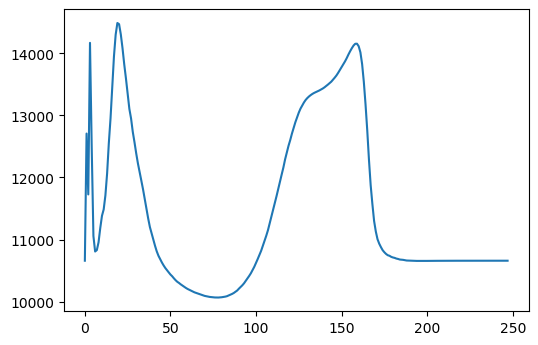

In [123]:
ixiuncertainty = mhue.get_uncertainty(ixiimage)
iximhue_img = mhue.get_HU(uncertainty=ixiuncertainty, homogeneity=ixischarr_n)
ixiuncertaintyw = mhue.get_uncertainty(ixiimage, off_center=False, info_w=True, stabs=ixistabs, 
                                       bdts_o=ixibdts_o, bdts_b=ixibdts_b,kernel_size=15,sigma=1)
iximhuew_img = mhue.get_HU(uncertainty=ixiuncertaintyw, homogeneity=ixischarr_n)

iximhue_cum = list(map(lambda x:np.sum(x),iximhue_img))
plt.plot(iximhue_cum)
print(argrelmin(np.array(iximhue_cum)))

In [124]:
ixischarr_nb, delta = bound.get_scharr_bounding(ixiimage, ixischarr_n, ixibdts_o, ixibdts_b, 60)

In [125]:
ixiscore = get_score(ixiimage,ixiuncertaintyw,ixischarr_n,3,bounding=False)

In [126]:
ixiscoreb = get_score(ixiimage,ixiuncertaintyw,ixischarr_nb,3,bounding=True)

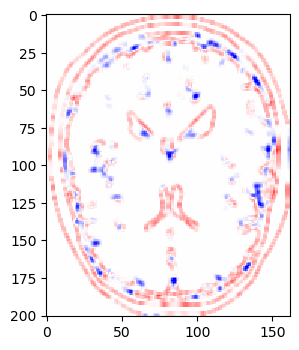

In [135]:
plt.imshow(ixiscoreb[80], cmap='bwr', norm=norm)

(array([ 66, 137, 179, 208]),)

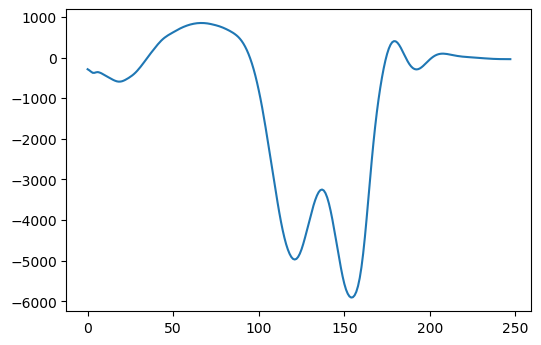

In [192]:
_r = list(map(lambda x:np.sum(x),ixiscoreb))
# _r = list(map(lambda x:np.sum(x),ixiscoreb))

_r_recon_all, _r_recon_hat, omega = VMD(_r, alpha=2000, tau=0.0, K=5, DC=0, init=1, tol=1e-7)
_r_recon = list(_r_recon_all[0,:])
for mode in range(1,_r_recon_all.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.1:
        _r_recon += _r_recon_all[mode,:]
        
plt.plot(_r_recon)
argrelmax(_r_recon, order=5)

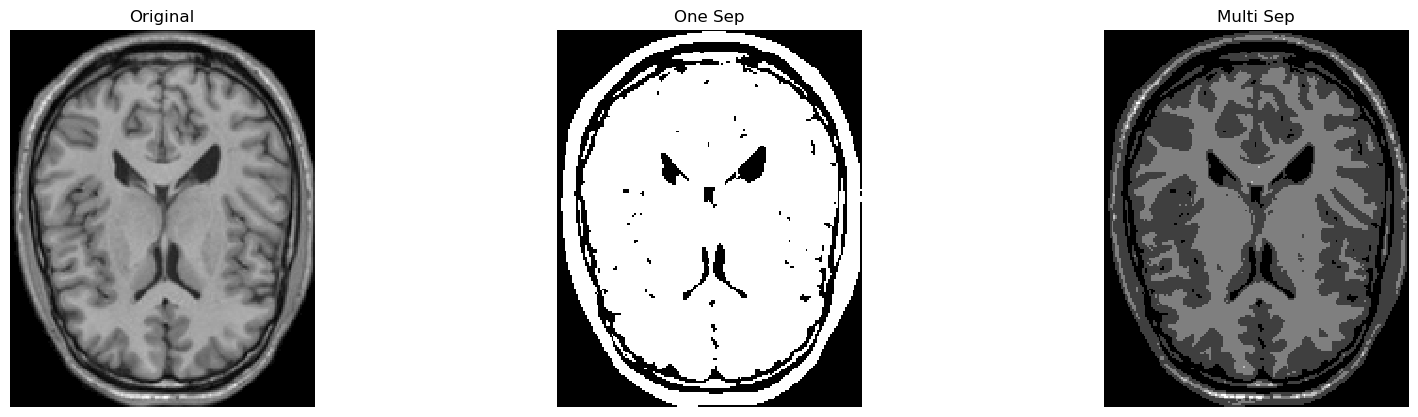

In [140]:
region_maxt = argrelmax(_r_recon, order=5)[0]
# region_maxt = np.array([95,130,180])
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.axis('off')
plt.title('Original')
plt.imshow(ixiimage,cmap='gray')

n_sep = region_maxt.size
sep = np.zeros(shape=ixiimage.shape) * 255
for n in range(n_sep):
    _,tmp = cv.threshold(ixiimage,region_maxt[n],255,0)
    if n==0:
        plt.subplot(132)
        plt.axis('off')
        plt.title('One Sep')
        plt.imshow(tmp,cmap='gray')
    sep[np.where(tmp==255)] = int(255*(n+1)/n_sep)
plt.subplot(133)
plt.axis('off')
plt.title('Multi Sep')
plt.imshow(sep,cmap='gray')

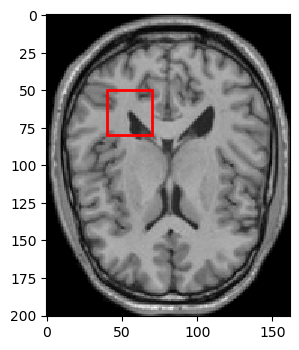

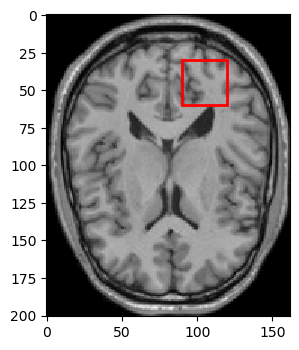

In [180]:
plt.figure()
plt.imshow(ixiimage)
# (min_row, min_col, max_row, max_col)
bbox = [50, 40, 80, 70]
bbox2 = [30, 90, 60, 120]
plt.gca().add_patch(plt.Rectangle(xy=(bbox[1], bbox[0]),width=bbox[3] - bbox[1], 
                                  height=bbox[2] - bbox[0], edgecolor='r', fill=False, linewidth=2))
plt.show()
plt.figure()
plt.imshow(ixiimage)
plt.gca().add_patch(plt.Rectangle(xy=(bbox2[1], bbox2[0]),width=bbox2[3] - bbox2[1], 
                                  height=bbox2[2] - bbox2[0], edgecolor='r', fill=False, linewidth=2))

mean: 0.000595, sum: 15.534834


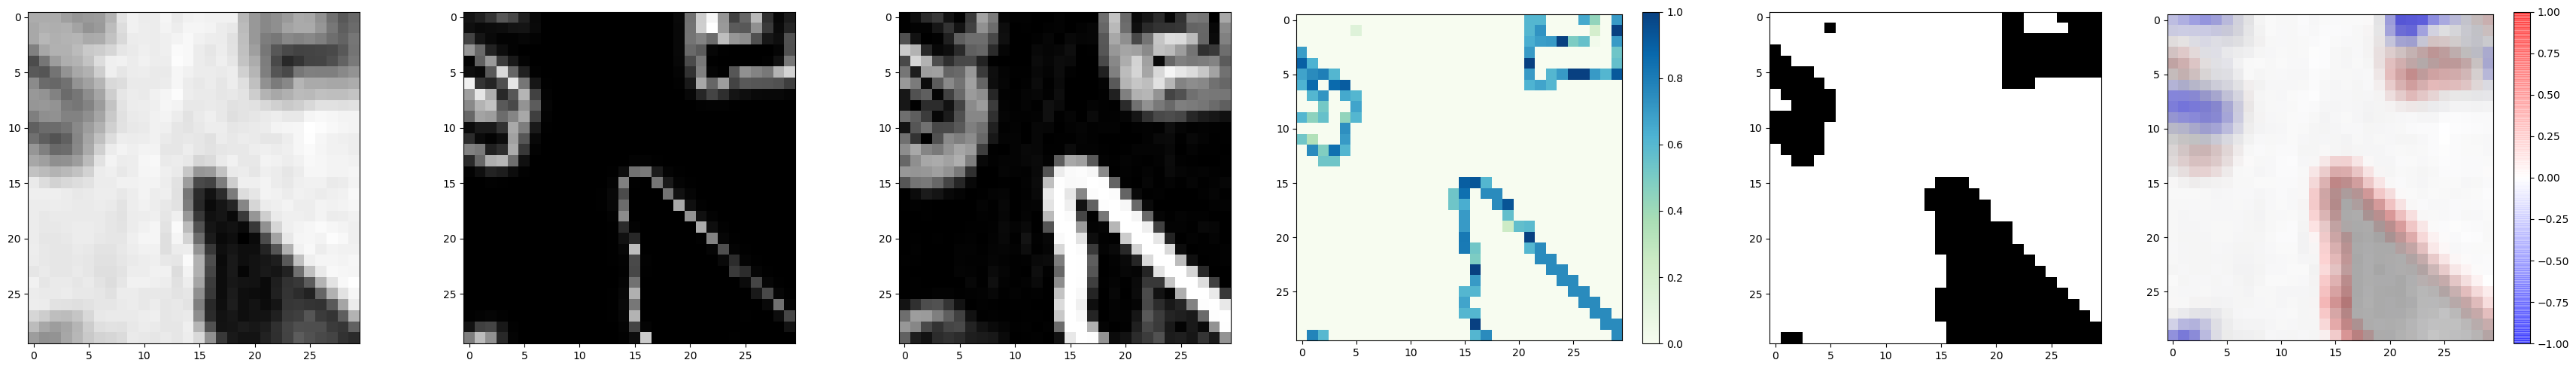

In [181]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox, 110)

mean: 0.000298, sum: 7.765578


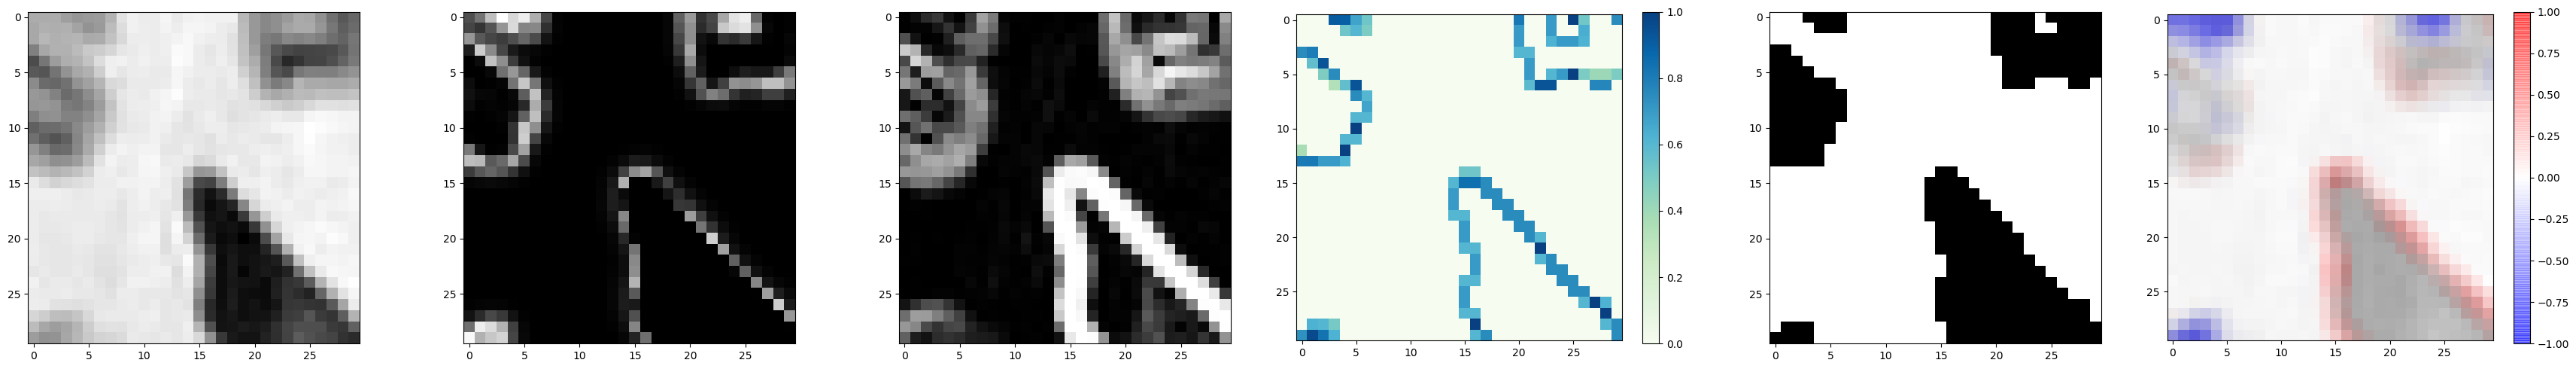

In [182]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox, 120)

mean: 0.000698, sum: 18.225875


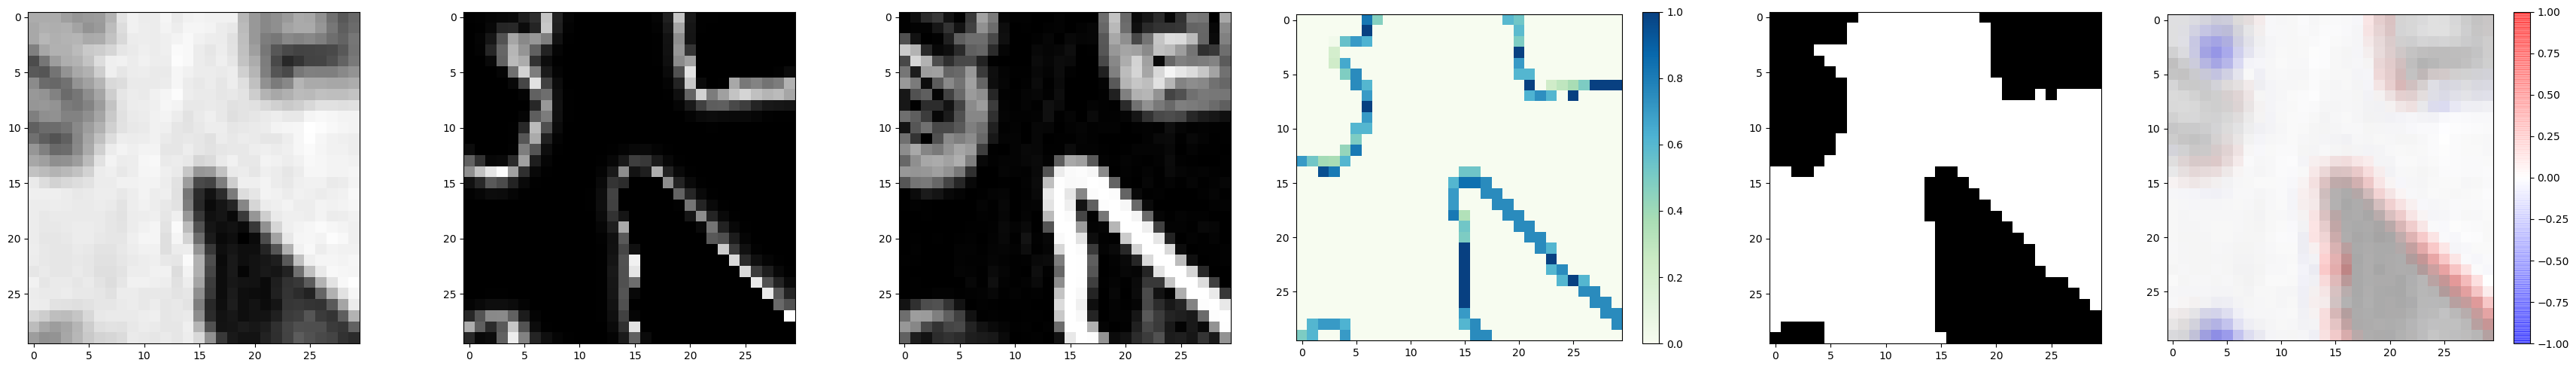

In [183]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox, 130)

mean: 0.000025, sum: 0.654004


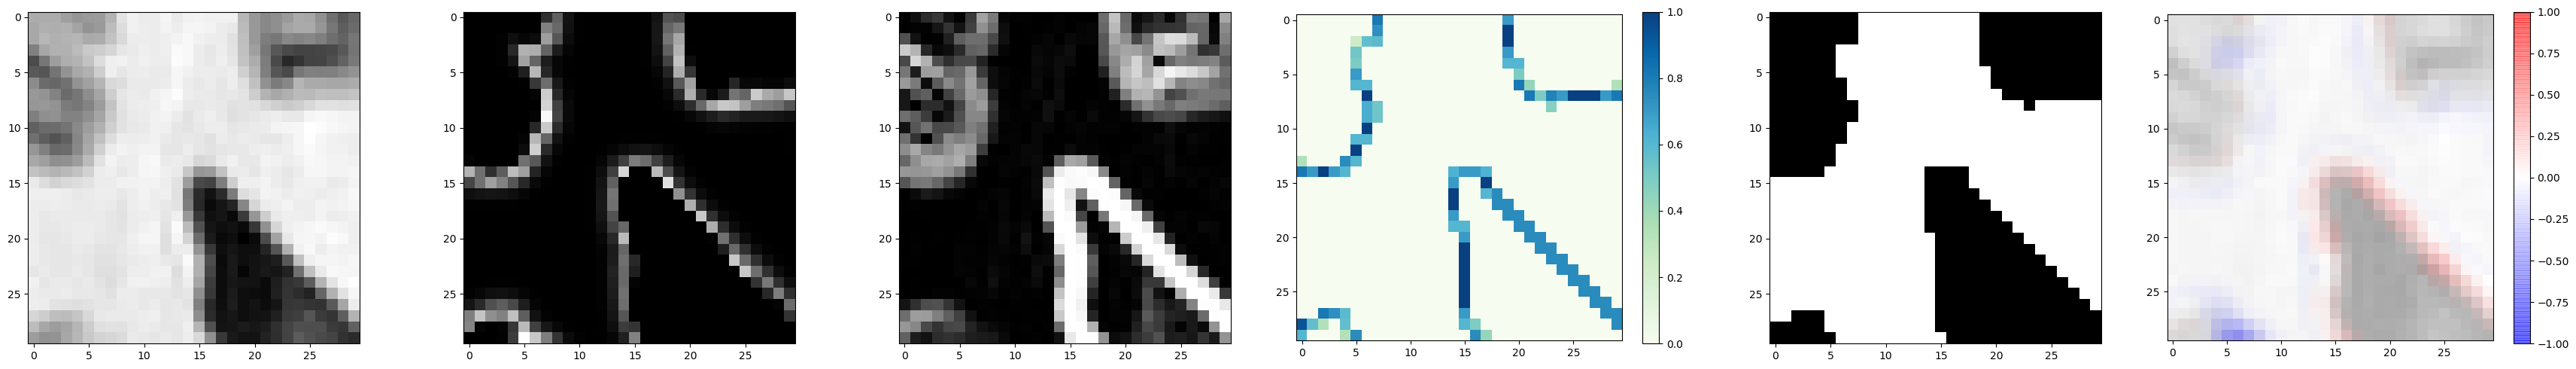

In [184]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox, 140)

mean: 0.000710, sum: 18.531883


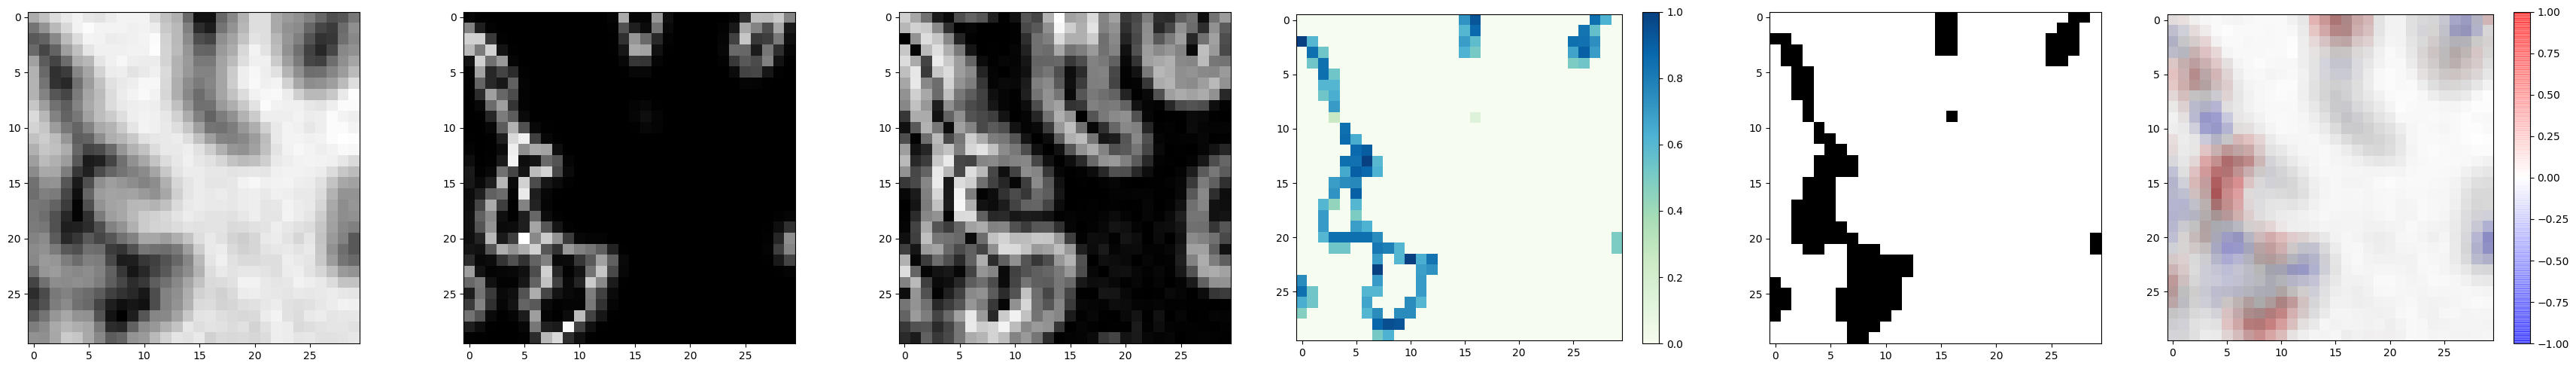

In [185]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox2, 100)

mean: 0.000623, sum: 15.204168


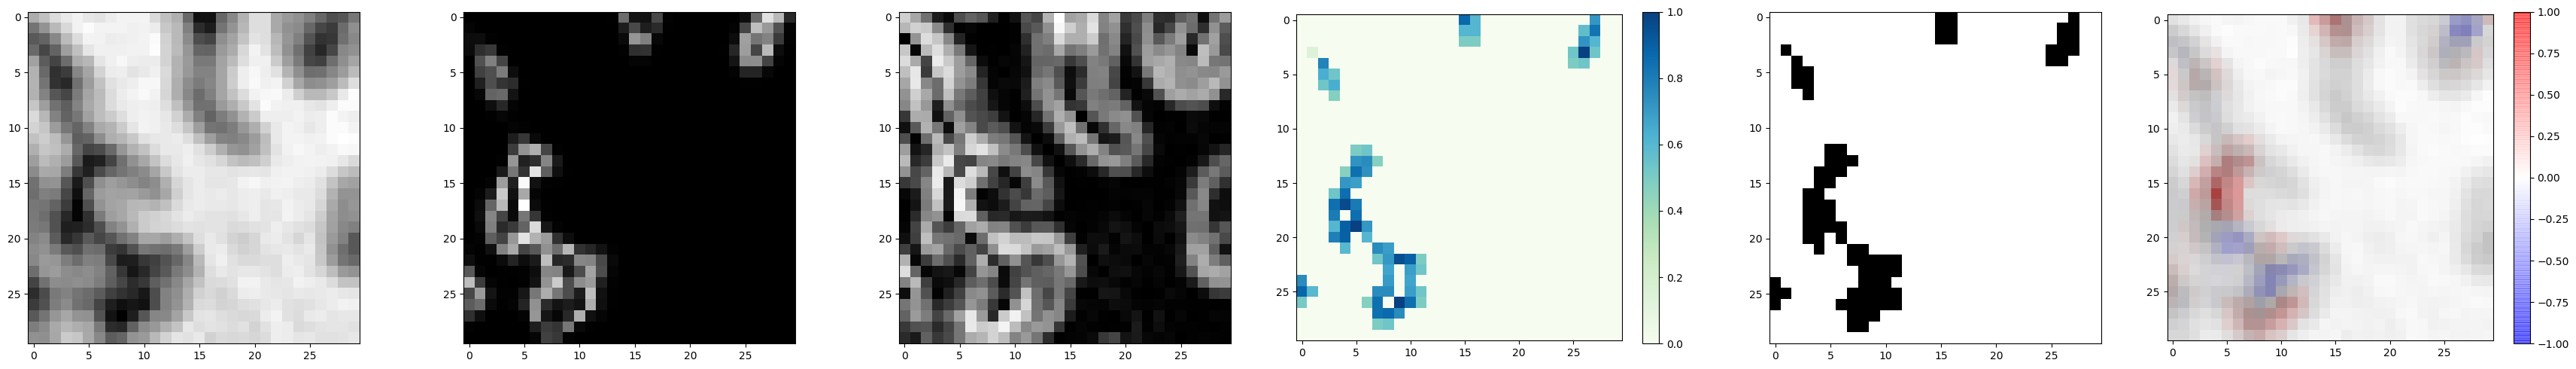

In [186]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox2, 90)

mean: 0.000710, sum: 18.531883


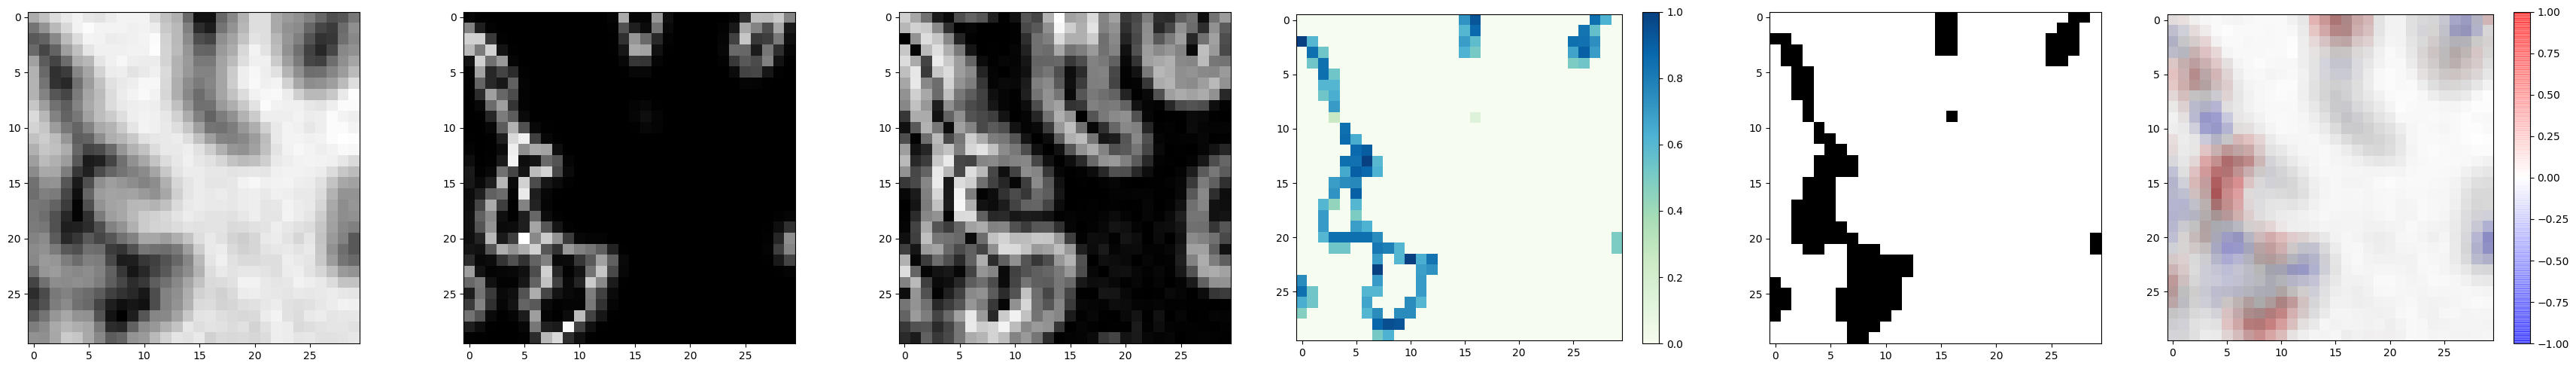

In [187]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox2, 100)

mean: -0.000361, sum: -9.433693


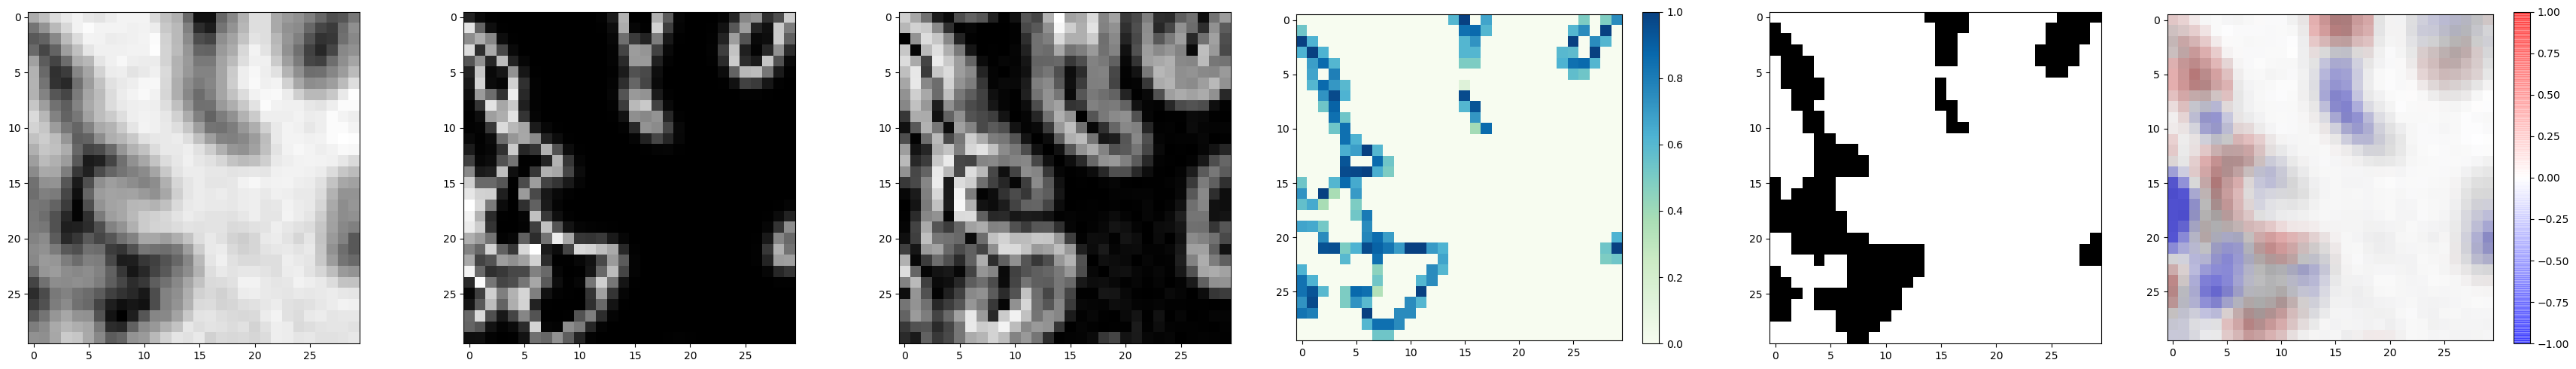

In [188]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox2, 110)

mean: -0.001288, sum: -33.608183


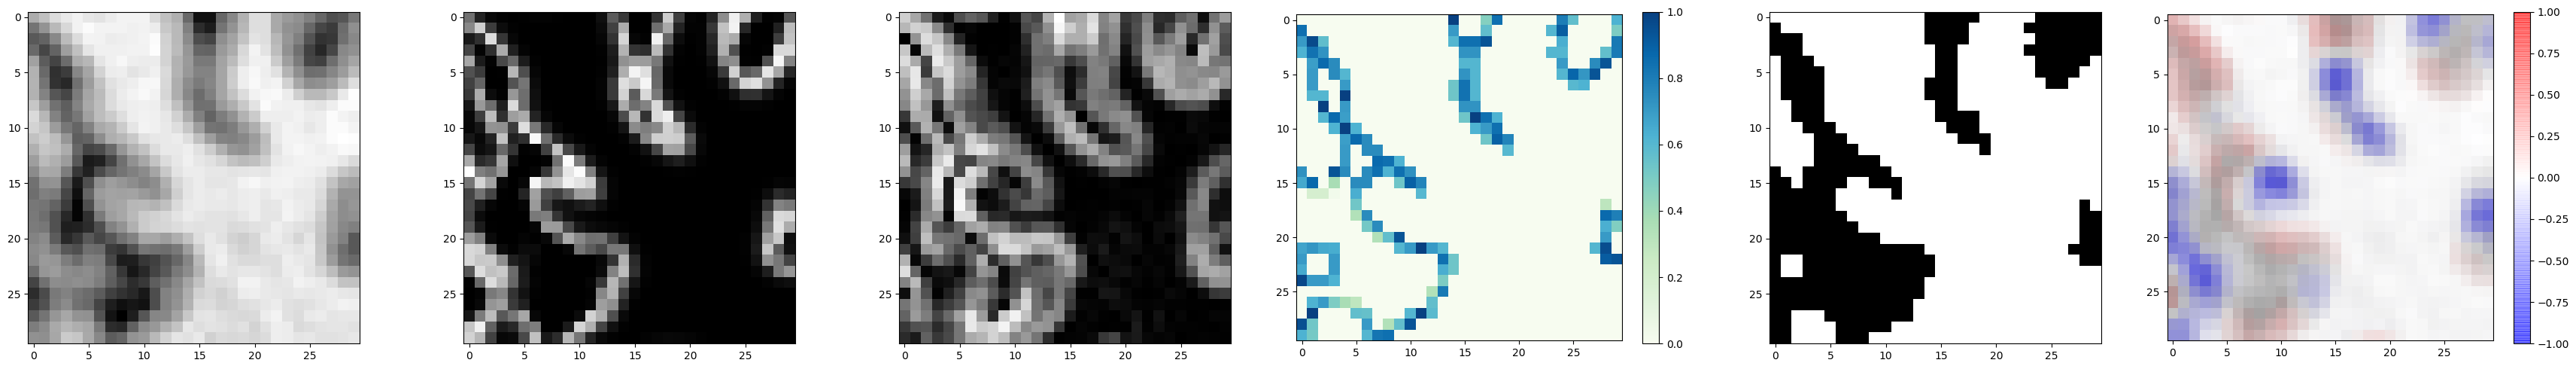

In [189]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox2, 120)

mean: -0.000640, sum: -16.710820


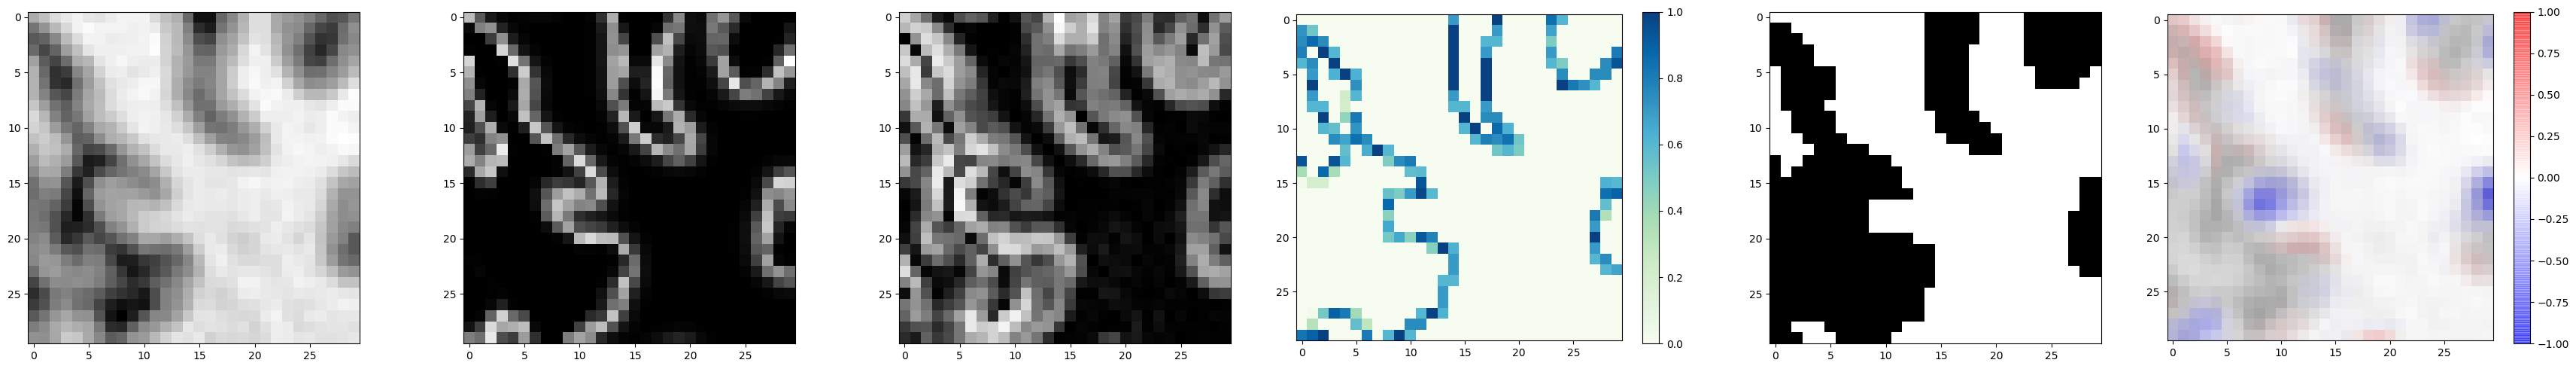

In [190]:
__partialplot(ixiimage, ixischarr_n, ixiuncertaintyw, ixiscore, ixistabs, bbox2, 130)

mean: -0.001888, sum: -49.269592


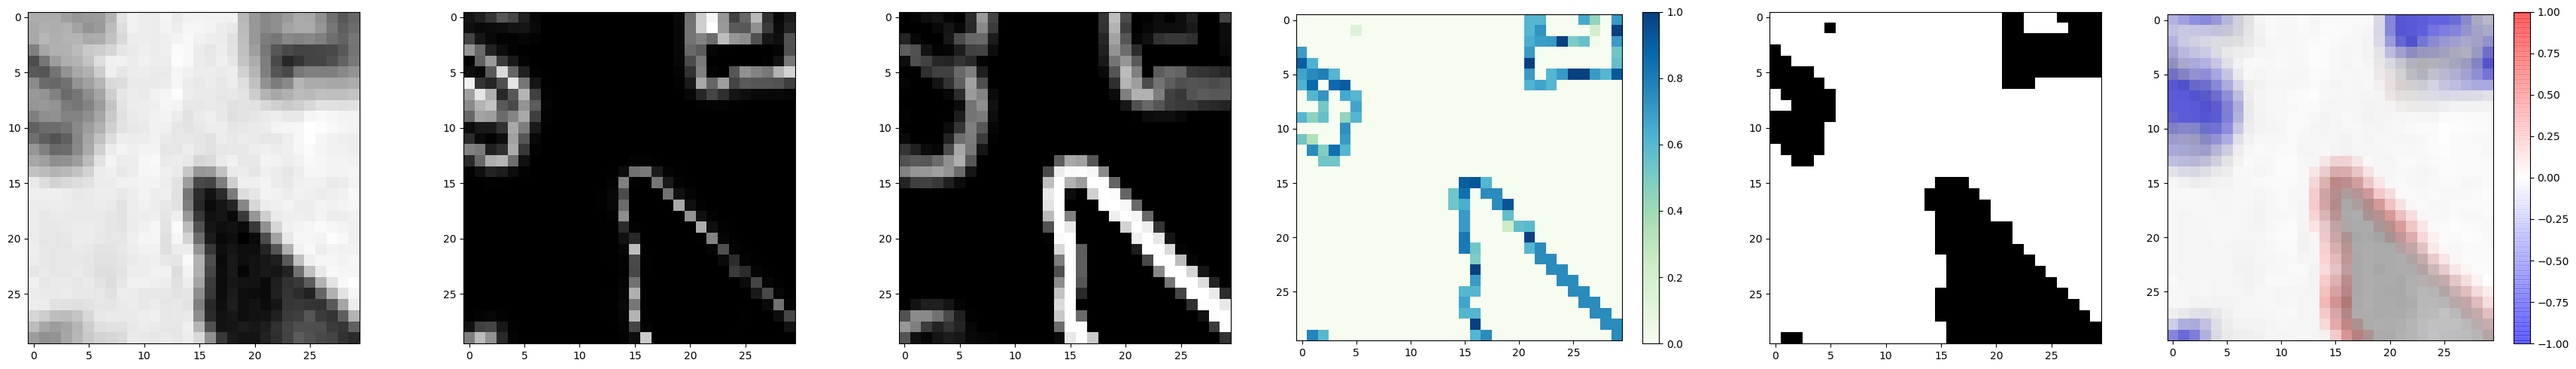

In [149]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox, 110, bounding=True)

mean: -0.002031, sum: -52.998343


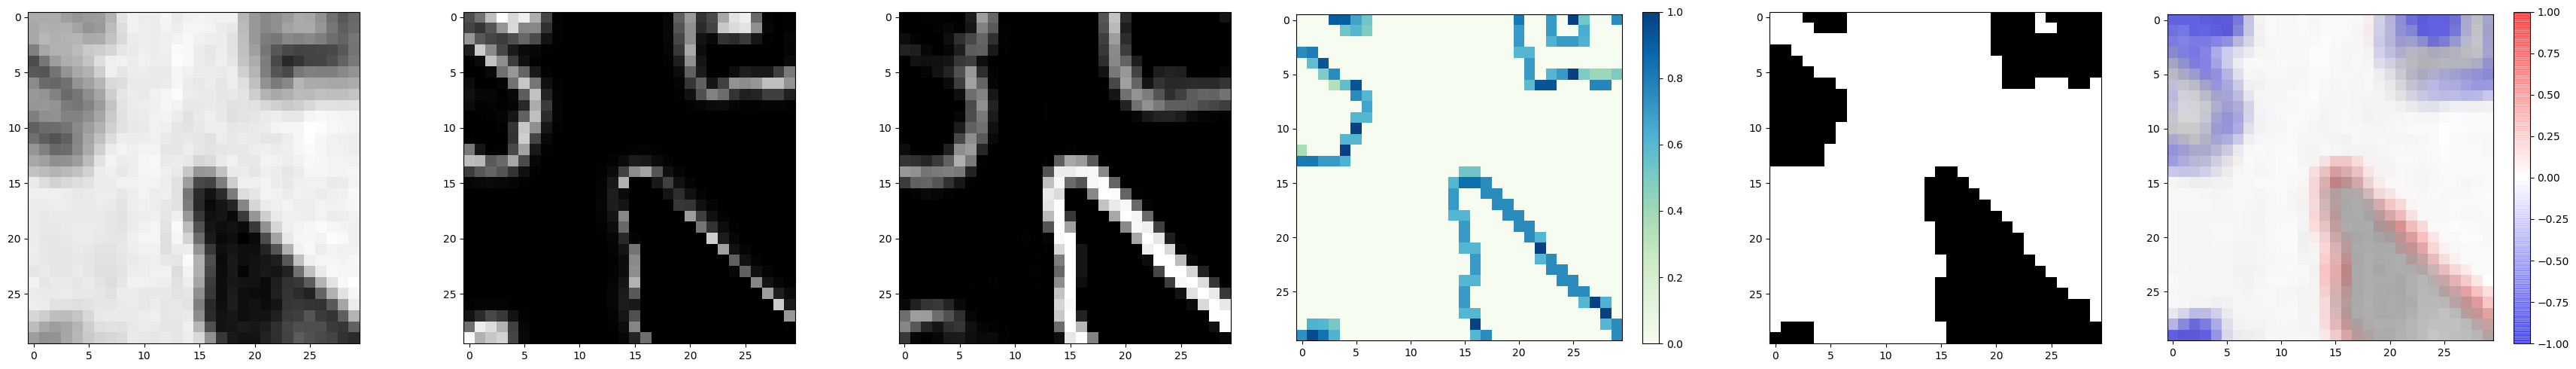

In [150]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox, 120, bounding=True)

mean: -0.001276, sum: -33.310204


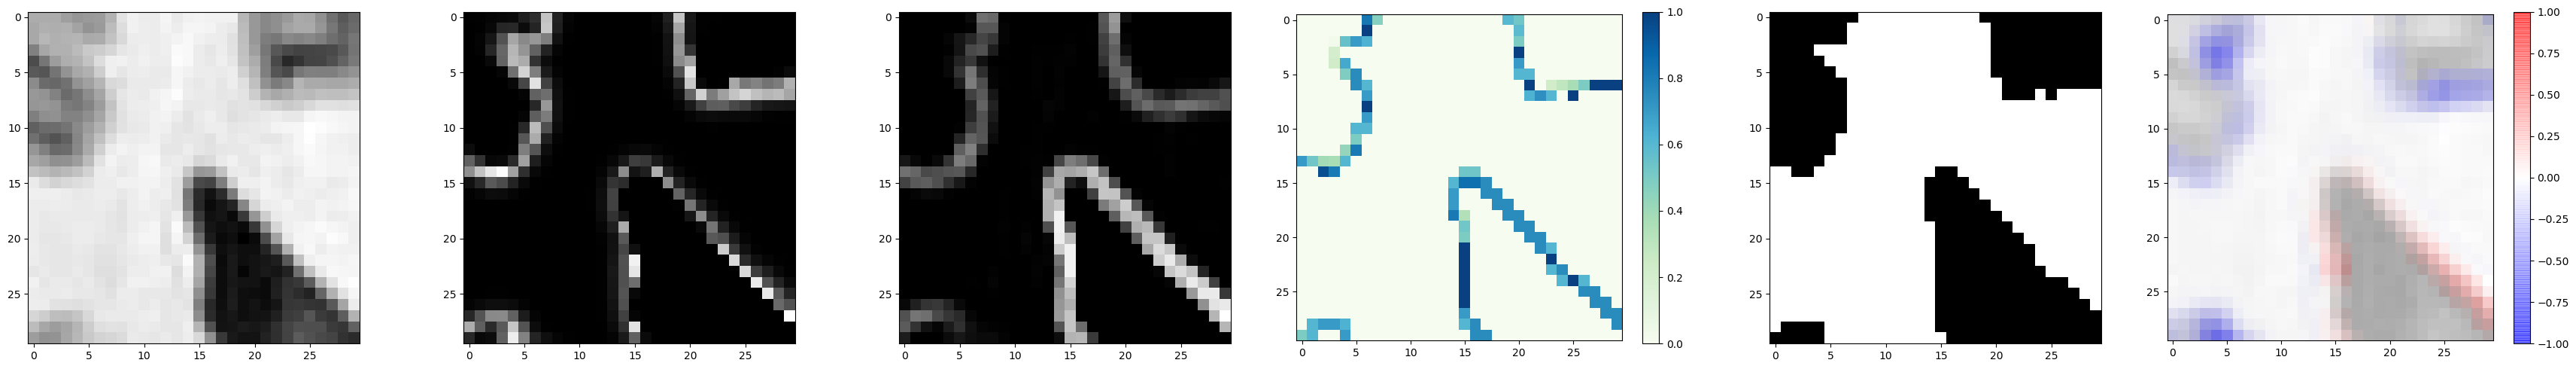

In [158]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox, 130, bounding=True)

mean: -0.002621, sum: -68.403003


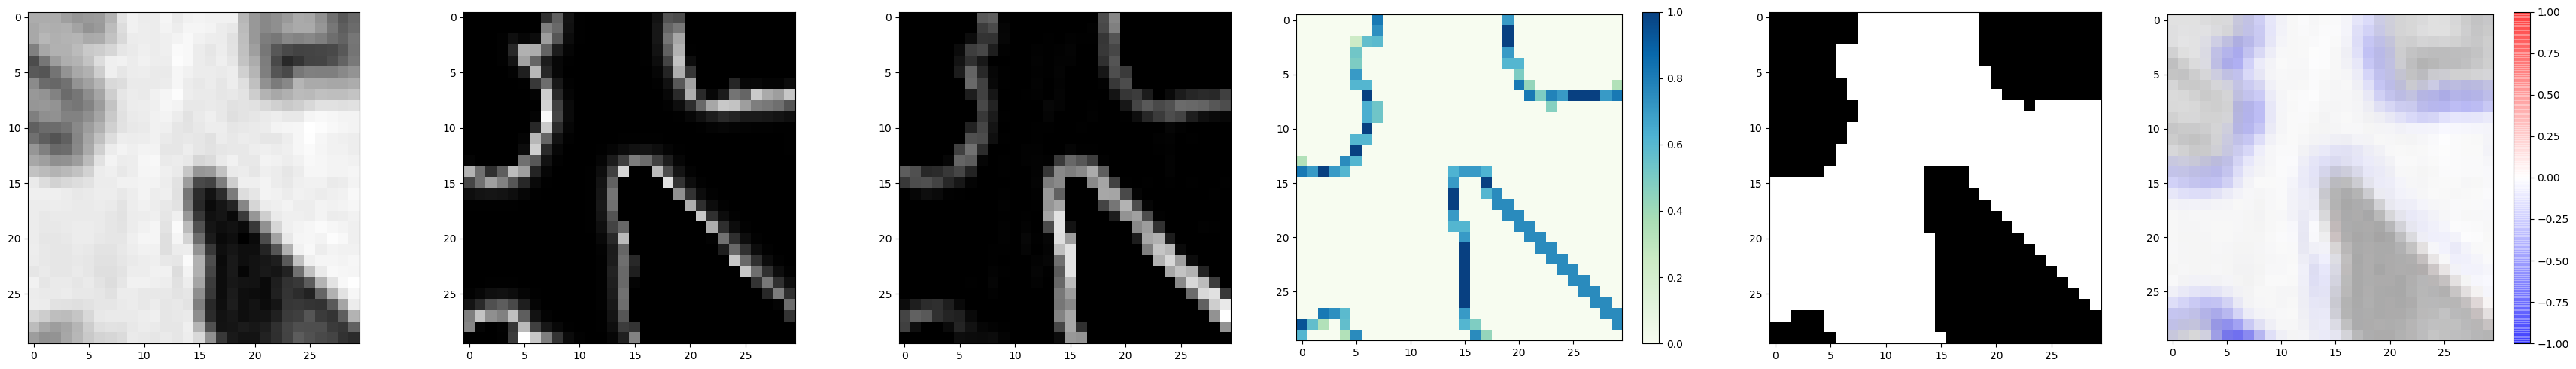

In [156]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox, 140, bounding=True)

mean: -0.005478, sum: -142.968914


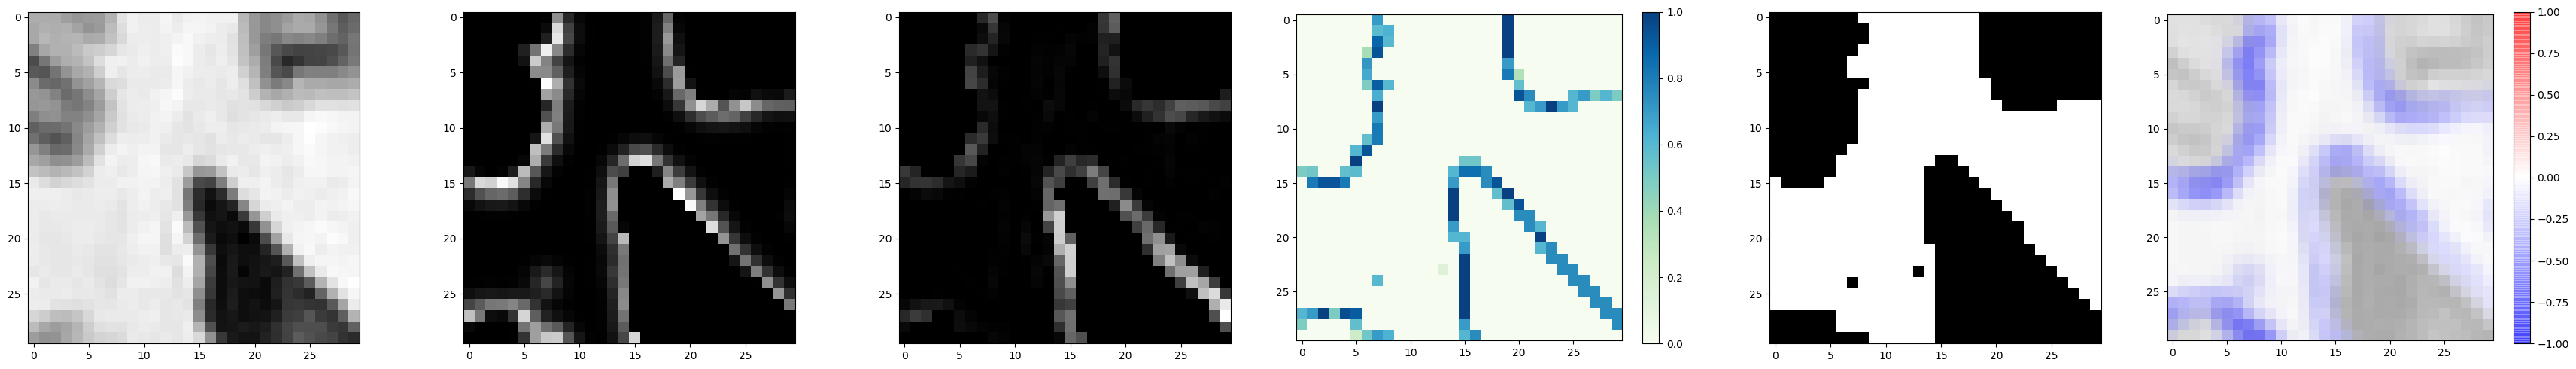

In [154]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox, 150, bounding=True)

Note: 梯度和灰度的微妙差异？

mean: -0.000572, sum: -13.289946


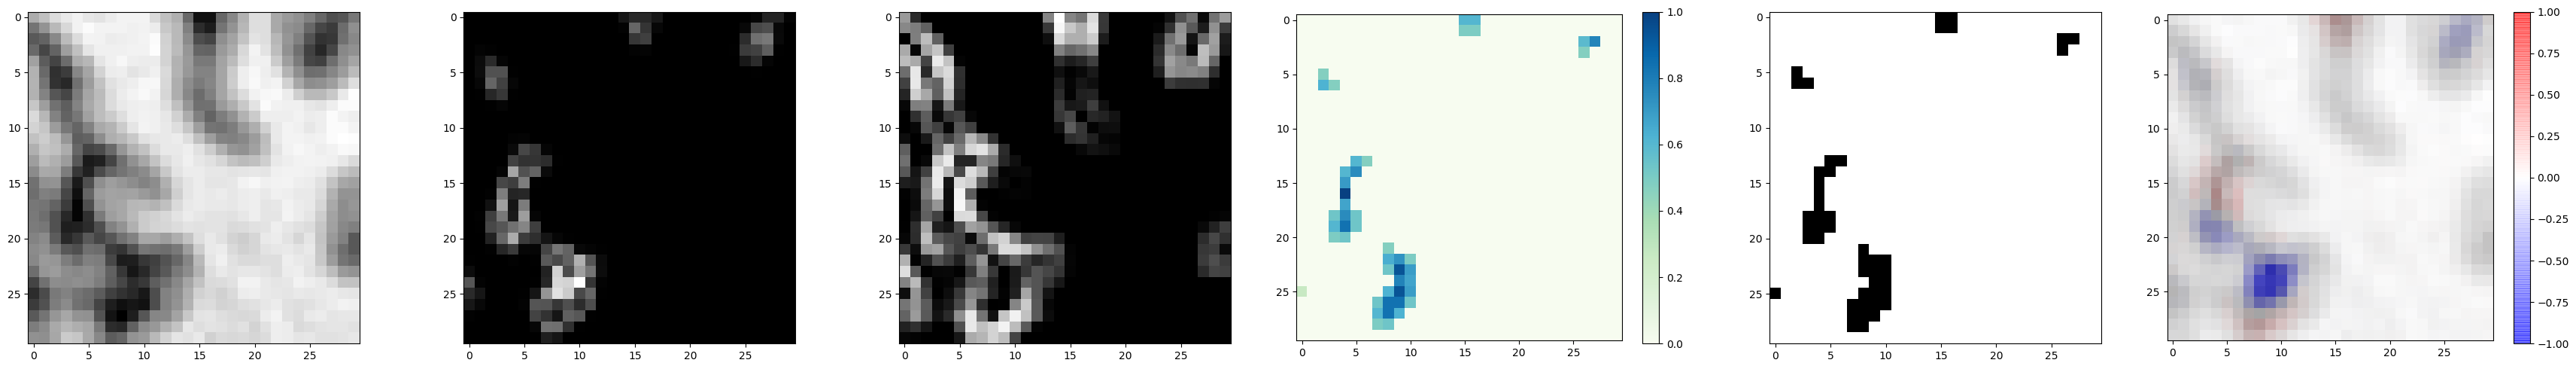

In [172]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox2, 80, bounding=True)

mean: -0.000907, sum: -22.133063


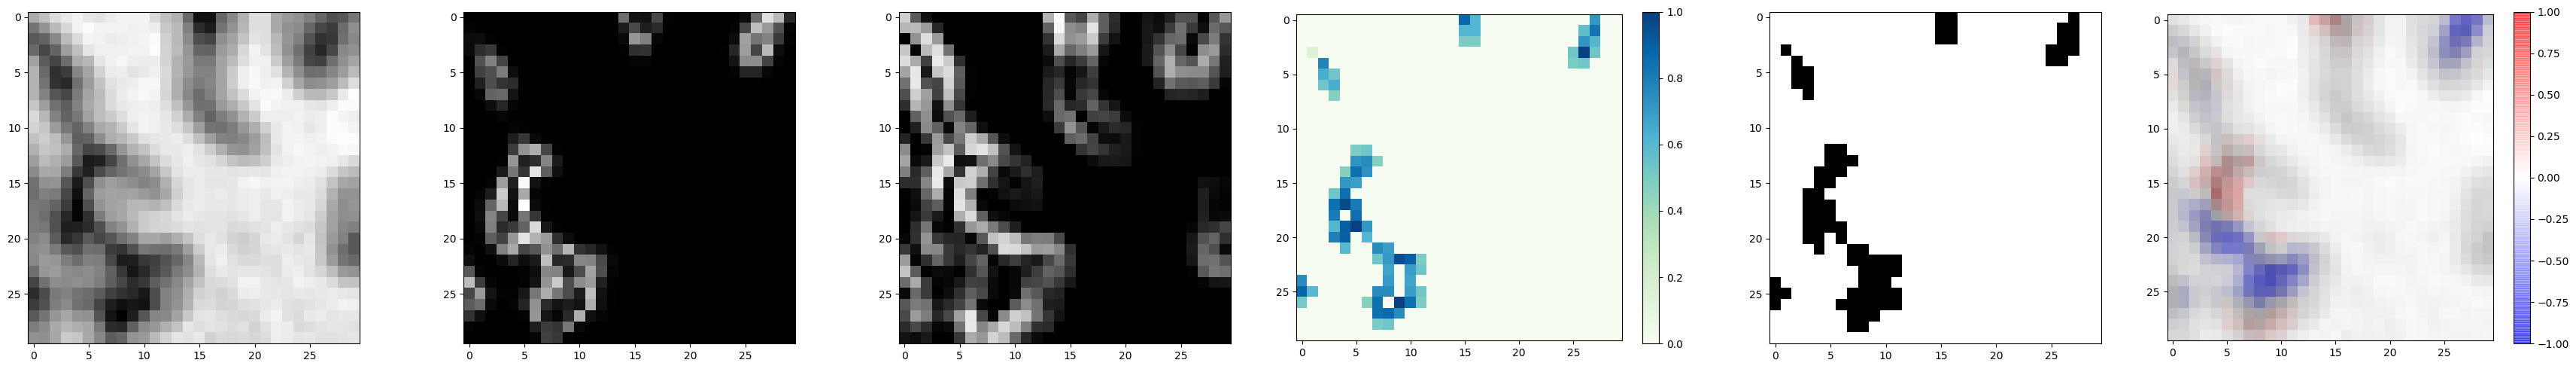

In [169]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox2, 90, bounding=True)

mean: -0.002247, sum: -58.642854


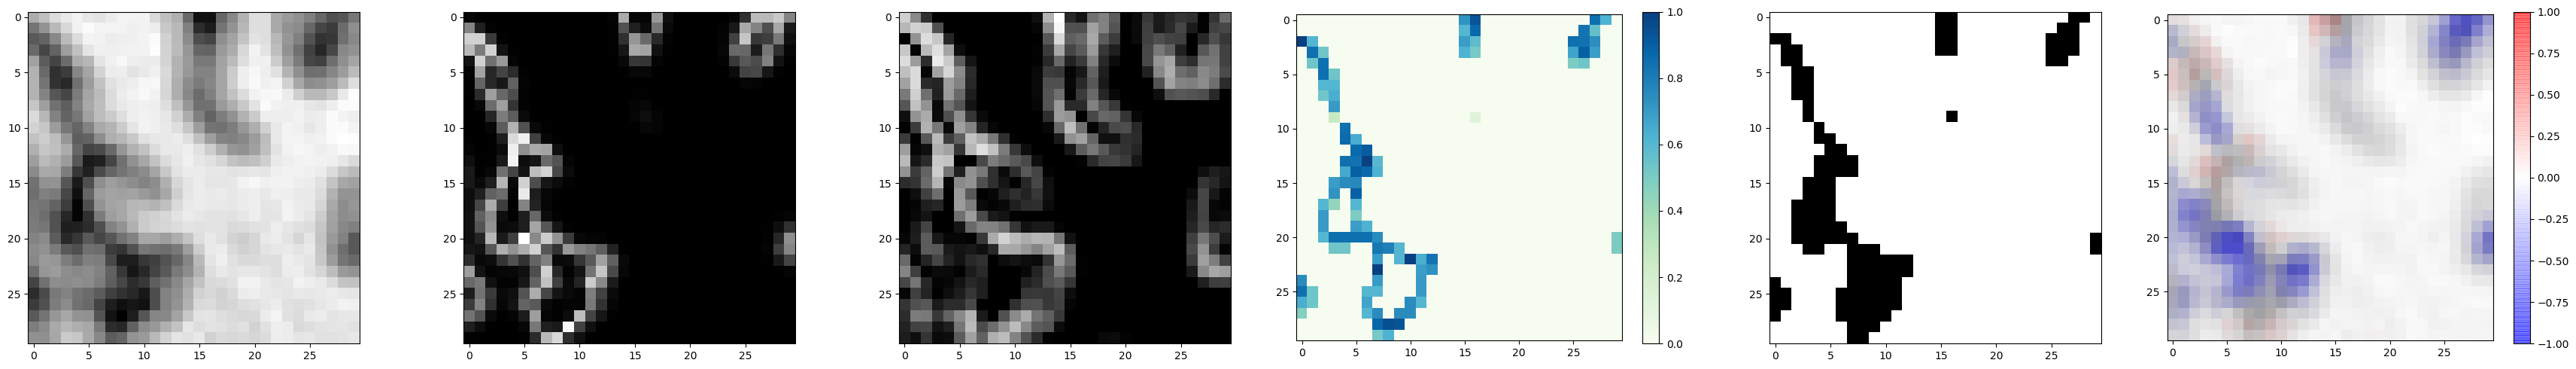

In [170]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox2, 100, bounding=True)

mean: -0.005667, sum: -147.917164


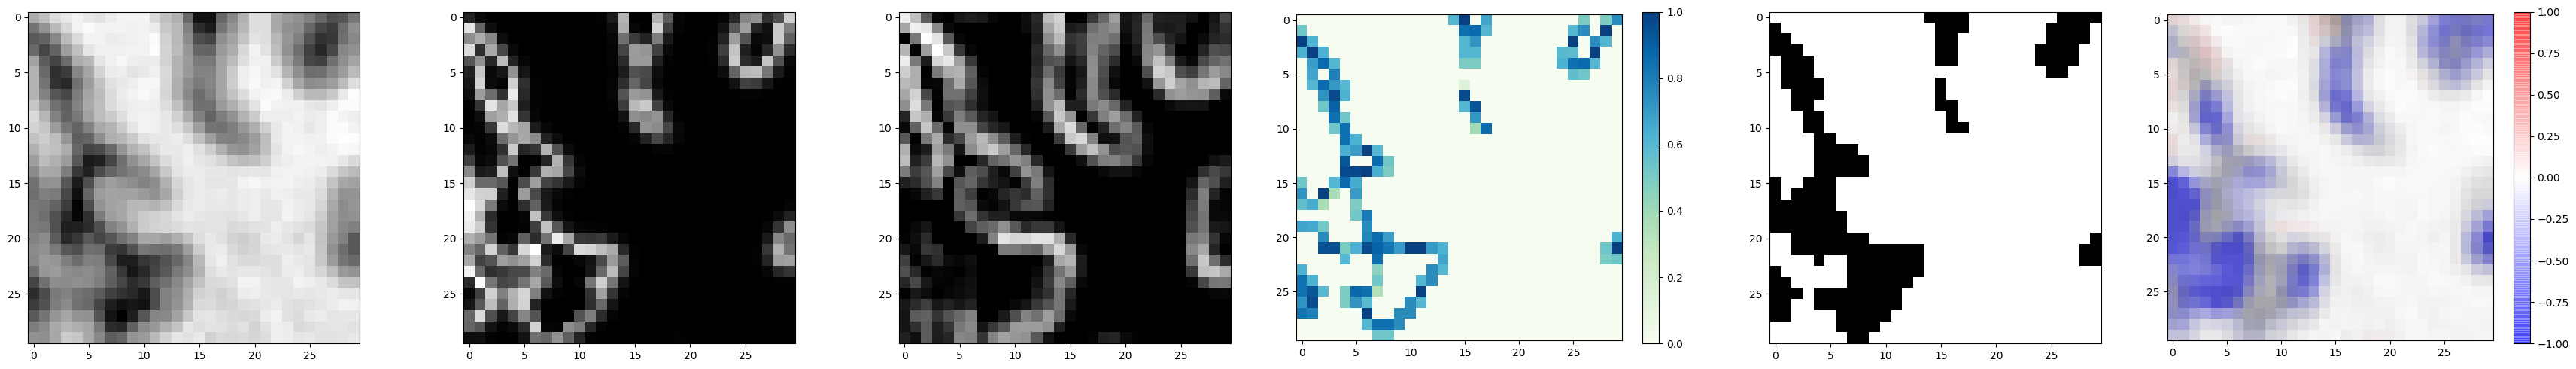

In [171]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox2, 110, bounding=True)

mean: -0.007242, sum: -189.019080


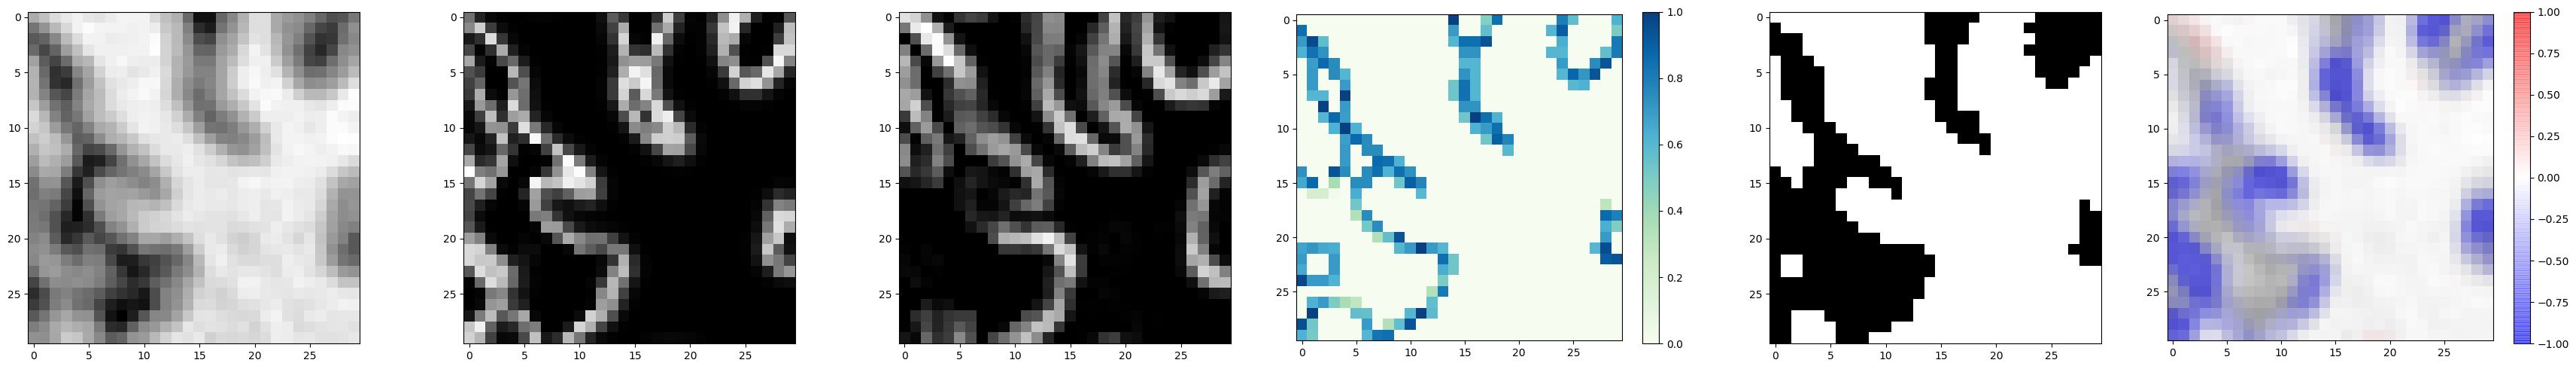

In [173]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox2, 120, bounding=True)

mean: -0.005313, sum: -138.680150


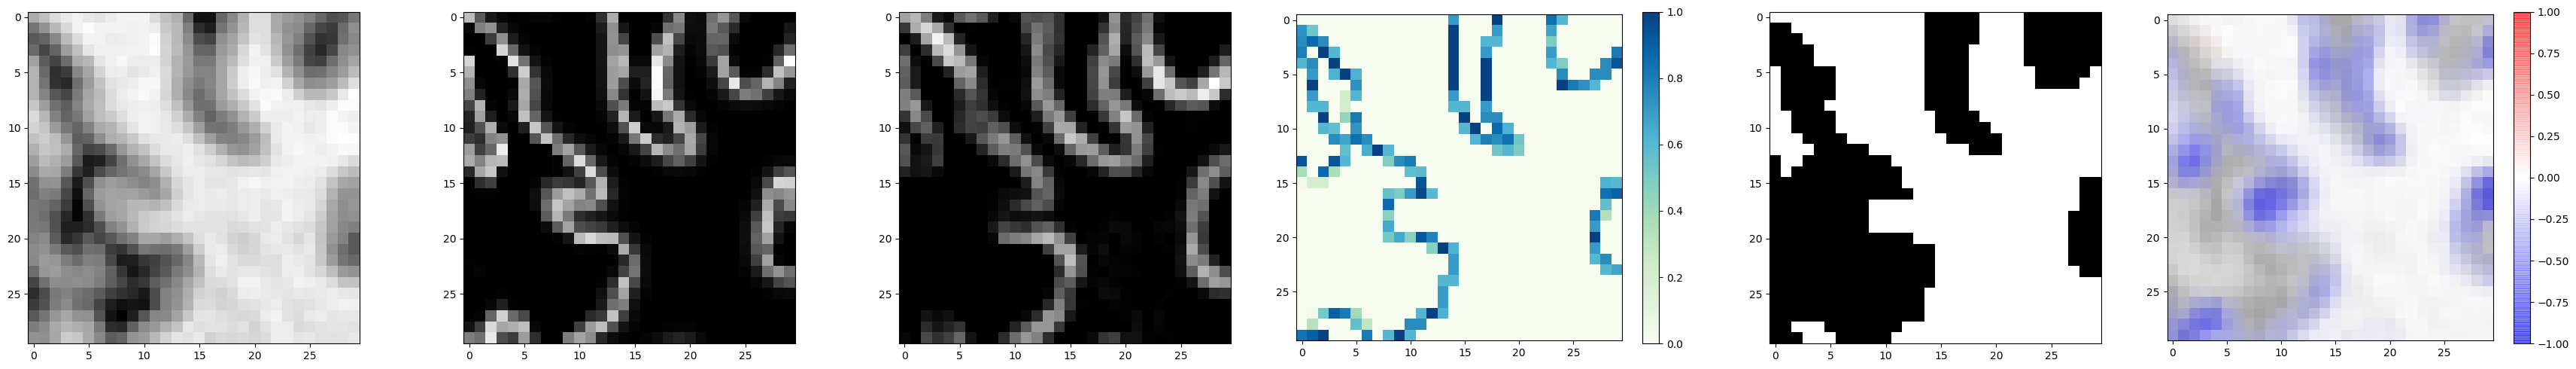

In [176]:
__partialplot(ixiimage, ixischarr_nb, ixiuncertaintyw, ixiscoreb, ixistabs, bbox2, 130, bounding=True)